**CSI 4106 Introduction to Artificial Intelligence** <br/>
*Assignment 3: Neural Networks*

# Identification

Name: Cole Stevens<br/>
Student Number: 300171413

Name: Mikaela Dobie<br/>
Student Number: 300164161

## 1. Exploratory Analysis

### Loading the dataset

A custom dataset has been created for this assignment. It has been made available on a public GitHub repository:

- [github.com/turcotte/csi4106-f24/tree/main/assignments-data/a3](https://github.com/turcotte/csi4106-f24/tree/main/assignments-data/a3)

Access and read the dataset directly from this GitHub repository in your Jupyter notebook.

You can use this code cell for your import statements and other initializations.

In [1]:
# Importing important libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

In [2]:
# Defining some column names to be used, so the first row of data doesn't get misinterpreted
column_names = ['target'] + [f'attr_{i}' for i in range(1, 463)]

# Loading the datasets
df_train = pd.read_csv("https://raw.githubusercontent.com/turcotte/csi4106-f24/main/assignments-data/a3/cb513_train.csv",
                       header=None, names=column_names)
df_test = pd.read_csv("https://raw.githubusercontent.com/turcotte/csi4106-f24/main/assignments-data/a3/cb513_test.csv",
                      header=None, names=column_names)
df_valid = pd.read_csv("https://raw.githubusercontent.com/turcotte/csi4106-f24/main/assignments-data/a3/cb513_valid.csv",
                       header=None, names=column_names)

### Data Pre-Processing

2. **Shuffling the Rows**:

    - Since examples are generated by sliding a window across each protein sequence, most adjacent examples originate from the same protein and share 20 positions. To mitigate the potential negative impact on model training, the initial step involves shuffling the **rows** of the data matrix.

In [3]:
# Shuffling the rows of the dataframes
# Including a random_state of 4106 for the sake of reproducibility
df_train = df_train.sample(frac=1, random_state=4106)
df_test = df_test.sample(frac=1, random_state=4106)
df_valid = df_valid.sample(frac=1, random_state=4106)

3. **Scaling of Numerical Features**:

    - Since all 462 features are proportions represented as values between 0 and 1, scaling may not be necessary. In our evaluations, using [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) actually degraded model performance. Within your pipeline, compare the effects of not scaling the data versus applying [MinMaxScaler](https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.MinMaxScaler.html). In the interest of time, a single experiment will suffice. It is important to note that when scaling is applied, a uniform method should be used across all columns, given their homogeneous nature.

In [4]:
# Initializing the MinMaxScaler
scaler = MinMaxScaler()

# Rescaling the numeric columns for every dataset (all columns except for the first one)
df_train_scaled = pd.DataFrame(df_train.iloc[:, :1].values)
df_train_scaled = pd.concat([df_train_scaled, pd.DataFrame(scaler.fit_transform(df_train.iloc[:, 1:]))], axis=1)
df_test_scaled = pd.DataFrame(df_test.iloc[:, :1].values)
df_test_scaled = pd.concat([df_test_scaled, pd.DataFrame(scaler.fit_transform(df_test.iloc[:, 1:]))], axis=1)
df_valid_scaled = pd.DataFrame(df_valid.iloc[:, :1].values)
df_valid_scaled = pd.concat([df_valid_scaled, pd.DataFrame(scaler.fit_transform(df_valid.iloc[:, 1:]))], axis=1)

4. **Isolating the Target and the Data**:

    - In the CSV files, the target and data are combined. To prepare for our machine learning experiments, separate the training data $X$ and the target vector $y$ for each of the three datasets.

In [5]:
# Splitting up the unscaled datasets
X_train, y_train = df_train.iloc[:, 1:], df_train.iloc[:, 0]
X_test, y_test = df_test.iloc[:, 1:], df_test.iloc[:, 0]
X_valid, y_valid = df_valid.iloc[:, 1:], df_valid.iloc[:, 0]

# Splitting up the scaled datasets
X_train_scaled, y_train_scaled = df_train_scaled.iloc[:, 1:], df_train_scaled.iloc[:, 0]
X_test_scaled, y_test_scaled = df_test_scaled.iloc[:, 1:], df_test_scaled.iloc[:, 0]
X_valid_scaled, y_valid_scaled = df_valid_scaled.iloc[:, 1:], df_valid_scaled.iloc[:, 0]

### Model Development & Evaluation

5. **Model Development**:

    - **Dummy Model**: Implement a model utilizing the [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html). This model disregards the input data and predicts the majority class. Such model is sometimes called a straw man model.

    - **Basline Model**: As a baseline model, select one of the previously studied machine learning algorithms: Decision Trees, K-Nearest Neighbors (KNN), or Logistic Regression. Use the default parameters provided by scikit-learn to train each model as a baseline. Why did you choose this particular classifier? Why do you think it should be appropriate for this specific task?

    - **Neural Network Model**: Utilizing [Keras](https://keras.io) and [TensorFlow](https://www.tensorflow.org), construct a sequential model comprising an input layer, a hidden layer, and an output layer. The input layer should consist of 462 nodes, reflecting the 462 attributes of each example. The hidden layer should include 8 nodes and employ the default activation function. The output layer should contain three nodes, corresponding to the three classes: helix (0), sheet (1), and coil (2). Apply the softmax activation function to the output layer to ensure that the outputs are treated as probabilities, with their sum equaling 1 for each training example.

    We therefore have three models: dummy, baseline, and neural network.

We have chosen the logistic regression approach. Logistic Regression was decided after a process of elimination. Put simply, K-NN seemed to be far too resource-demanding and inefficient for such a numbers-heavy dataset, and the Decision Tree structure didn't seem like it would be able to effectively define rules that would allow for the best possible predictions to be made.

In [6]:
# 1. DUMMY MODEL
# Initializing the Dummy models
dummy_model = DummyClassifier()
dummy_model_scaled = DummyClassifier()

# Training the dummy models
dummy_model.fit(X_train, y_train)
dummy_model_scaled.fit(X_train_scaled, y_train_scaled)

DummyClassifier()

In [7]:
# 2. BASELINE MODEL
# Initializing the Logistic Regression models
baseline_model  = LogisticRegression()
baseline_scaled_model = LogisticRegression()

# Training the baseline models
baseline_model.fit(X_train, y_train)
baseline_scaled_model.fit(X_train_scaled, y_train_scaled)

LogisticRegression()

In [8]:

# Define the layers for the neural network
layers = [
    keras.layers.Dense(462, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
]

# Initializing the neural network models
nn_model = keras.Sequential(layers)
nn_scaled_model = keras.Sequential(layers)

# Obtaining a categorical version of the target variable columns
y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_train_scaled_categorical = tf.keras.utils.to_categorical(y_train_scaled, num_classes=3)
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes=3)
y_test_scaled_categorical = tf.keras.utils.to_categorical(y_test_scaled, num_classes=3)
y_valid_categorical = tf.keras.utils.to_categorical(y_valid, num_classes=3)
y_valid_scaled_categorical = tf.keras.utils.to_categorical(y_valid_scaled, num_classes=3)

# Compile the models with appropriate parameters
nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
nn_scaled_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the models
nn_model.fit(X_train, y_train_categorical, epochs=50, batch_size=32, validation_data=(X_test, y_test_categorical), verbose=2)
nn_scaled_model.fit(X_train_scaled, y_train_scaled_categorical, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test_scaled_categorical), verbose=2)

Epoch 1/50
1822/1822 - 7s - loss: 0.7625 - accuracy: 0.6739 - val_loss: 0.6773 - val_accuracy: 0.7150 - 7s/epoch - 4ms/step
Epoch 2/50
1822/1822 - 6s - loss: 0.6509 - accuracy: 0.7305 - val_loss: 0.6480 - val_accuracy: 0.7291 - 6s/epoch - 3ms/step
Epoch 3/50
1822/1822 - 6s - loss: 0.5490 - accuracy: 0.7792 - val_loss: 0.6731 - val_accuracy: 0.7243 - 6s/epoch - 3ms/step
Epoch 4/50
1822/1822 - 6s - loss: 0.4252 - accuracy: 0.8341 - val_loss: 0.7132 - val_accuracy: 0.7209 - 6s/epoch - 3ms/step
Epoch 5/50
1822/1822 - 6s - loss: 0.3022 - accuracy: 0.8883 - val_loss: 0.8806 - val_accuracy: 0.6986 - 6s/epoch - 3ms/step
Epoch 6/50
1822/1822 - 6s - loss: 0.2071 - accuracy: 0.9257 - val_loss: 1.0457 - val_accuracy: 0.7043 - 6s/epoch - 3ms/step
Epoch 7/50
1822/1822 - 6s - loss: 0.1445 - accuracy: 0.9494 - val_loss: 1.1717 - val_accuracy: 0.6962 - 6s/epoch - 3ms/step
Epoch 8/50
1822/1822 - 6s - loss: 0.1083 - accuracy: 0.9621 - val_loss: 1.4306 - val_accuracy: 0.6973 - 6s/epoch - 3ms/step
Epoch 9/

6. **Model Evaluation**:

    - Employ cross-validation to assess the performance of the baseline model. Select a small number of folds to prevent excessive computational demands.
    - **Training neural networks can be time-consuming.** Consequently, their performance is typically assessed once using a validation set. Make sure to not use the test set until the very end of the assignment.
    - Assess the models using metrics such as precision, recall, and F1-score.

For the baseline, there were scores around 0.68 across the board, which suggests it performs reasonably well (not great) while balancing precision and recall, which is a good sign. In contrast, the dummy model performed very poorly in both the scaled and unscaled versions. Both precision and recall are low, but recall is considerably higher than precision, which suggests that it may be more tolerant of false positives. The neural network model achieves scores around the 0.66 range across all metrics, which is comparable to the baseline model, but it is lower, suggesting that the hyperparameters that the neural network are set to do not beat out the default hyperparameters of the baseline model. It is important to note however, despite both the scaled and unscaled versions of the NN model being similar, the unscaled version does do ever so slightly better than the scaled version, further validating the earlier claim in this assignments' instructions that unscaled may be better than scaled.

In [9]:
# Creating a blank Logistic Regression model to perform CV on
baseline_eval = LogisticRegression()

# Defining which metrics we'd like to evaluate in CV
eval_metrics = ['precision_weighted', 'recall_weighted', 'f1_weighted']

# Computing the CV predictions for baseline model
baseline_cv_predictions = cross_val_predict(baseline_eval, X_train, y_train, cv=5)
baseline_cv_precision = precision_score(y_train, baseline_cv_predictions, average='weighted')
baseline_cv_recall = recall_score(y_train, baseline_cv_predictions, average='weighted')
baseline_cv_f1 = f1_score(y_train, baseline_cv_predictions, average='weighted')

# Displaying the CV predictions for baseline model
print("CV Metrics for Baseline Model:")
print("Precision:", baseline_cv_precision)
print("Recall:", baseline_cv_recall)
print("F1-score:", baseline_cv_f1)

CV Metrics for Baseline Model:
Precision: 0.6844317695559626
Recall: 0.6866926283645846
F1-score: 0.6833900457105222


In [15]:
# Evaluating the Dummy model on the validation set
dummy_predictions = dummy_model.predict(X_valid)
dummy_precision = precision_score(y_valid, dummy_predictions, average='weighted')
dummy_recall = recall_score(y_valid, dummy_predictions, average='weighted')
dummy_f1 = f1_score(y_valid, dummy_predictions, average='weighted')

dummy_predictions_scaled = dummy_model.predict(X_valid_scaled)
dummy_precision_scaled = precision_score(y_valid_scaled, dummy_predictions_scaled, average='weighted')
dummy_recall_scaled = recall_score(y_valid_scaled, dummy_predictions_scaled, average='weighted')
dummy_f1_scaled = f1_score(y_valid_scaled, dummy_predictions_scaled, average='weighted')

# Displaying the Dummy predictions
print("Dummy Model Regular:")
print("Precision:", dummy_precision)
print("Recall:", dummy_recall)
print("F1-score:", dummy_f1)

# Displaying the Dummy predictions
print("Dummy Model Scaled:")
print("Precision:", dummy_precision_scaled)
print("Recall:", dummy_recall_scaled)
print("F1-score:", dummy_f1_scaled)

Dummy Model Regular:
Precision: 0.17631157809641587
Recall: 0.41989472263463357
F1-score: 0.24834457834911502
Dummy Model Scaled:
Precision: 0.17631157809641587
Recall: 0.41989472263463357
F1-score: 0.24834457834911502


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
# Evaluating the NN model on the validation set
nn_predictions = nn_model.predict(X_valid).argmax(axis=1)
nn_precision = precision_score(y_valid, nn_predictions, average='weighted')
nn_recall = recall_score(y_valid, nn_predictions, average='weighted')
nn_f1 = f1_score(y_valid, nn_predictions, average='weighted')

nn_predictions_scaled = nn_model.predict(X_valid_scaled).argmax(axis=1)
nn_precision_scaled = precision_score(y_valid_scaled, nn_predictions_scaled, average='weighted')
nn_recall_scaled = recall_score(y_valid_scaled, nn_predictions_scaled, average='weighted')
nn_f1_scaled = f1_score(y_valid_scaled, nn_predictions_scaled, average='weighted')


# Displaying the NN predictions
print(f"NN Model Regular:")
print("Precision:", nn_precision)
print("Recall:", nn_recall)
print("F1-score:", nn_f1)

# Displaying the NN predictions
print(f"NN Model Scaled:")
print("Precision:", nn_precision_scaled)
print("Recall:", nn_recall_scaled)
print("F1-score:", nn_f1_scaled)

232/232 [==============================] - 0s 2ms/step
NN Model Regular:
Precision: 0.6636372859182251
Recall: 0.6652719665271967
F1-score: 0.6630769177163978
NN Model Scaled:
Precision: 0.6632065659632328
Recall: 0.6648670535834795
F1-score: 0.6627004026391241


### Hyperparameter Optimization

7. **Baseline Model:**

    - To ensure a fair comparison for our baseline model, we will examine how varying hyperparameter values affect its performance. This prevents the erroneous conclusion that neural networks inherently perform better, when in fact, appropriate hyperparameter tuning could enhance the baseline model's performance.

    - Focus on the following relevant hyperparameters for each model:

        - [DecisionTreeClassifier](https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeClassifier.html): `criterion` and `max_depth`.
  
        - [LogisticRegression](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html): `penalty`, `max_iter`, and `tol`.
  
        - [KNeighborsClassifier](https://scikit-learn.org/dev/modules/generated/sklearn.neighbors.KNeighborsClassifier.html): `n_neighbors` and `weights`.

    - Employ a grid search strategy or utilize scikit-learn's built-in methods [GridSearchCV](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html) to thoroughly evaluate all combinations of hyperparameter values. Cross-validation should be used to assess each combination.

    - Quantify the performance of each hyperparameter configuration using precision, recall, and F1-score as metrics.

    - Analyze the findings and offer insights into which hyperparameter configurations achieved optimal performance for each model.

In our gridsearch, we attempted different values for the penalty, max_iter, and tol hyperparameters. After many trial-and-error attempts, having a very high max-iter (e.g. 500) led to unnessarily high run times which made us conclude that a small range from 50 to 100 would be best. Despite this limitation, precision, recall, and F1 remained remarkably consistent across all fronts no matter what values were chosen. The only exception was that l2 performed slightly better than l1 for penalty. The system determined from our given values, the best hyperparameter configuration was a penalty of l2, max_iter of 50, and a tol of 0.001. This suggests that having the max_iter range may not have been a bad thing, since a smaller max_iter value was selected as being the best.

In [14]:
# Defining the hyperparameter possibilities to search through
param_grid = {
    'penalty': ['l1', 'l2'],
    'max_iter': [50, 75, 100],
    'tol': [1e-5, 1e-4, 1e-3]
}

# Initializing the Logistic Regression model
baseline_gridsearch = LogisticRegression(solver='saga')

# Define scoring metrics
gridsearch_metrics = {
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# Initializing the GridSearchCV
grid_search = GridSearchCV(estimator=baseline_gridsearch, param_grid=param_grid, scoring=gridsearch_metrics,
                           cv=3, refit='f1', verbose=2, return_train_score=True)

# Fitting the grid search to the training data
grid_search.fit(X_train, y_train)

# Getting the best hyperparameter settings
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................max_iter=50, penalty=l1, tol=1e-05; total time=  29.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................max_iter=50, penalty=l1, tol=1e-05; total time=  29.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................max_iter=50, penalty=l1, tol=1e-05; total time=  29.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ................max_iter=50, penalty=l1, tol=0.0001; total time=  29.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ................max_iter=50, penalty=l1, tol=0.0001; total time=  29.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ................max_iter=50, penalty=l1, tol=0.0001; total time=  29.8s
[CV] END .................max_iter=50, penalty=l1, tol=0.001; total time=  27.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................max_iter=50, penalty=l1, tol=0.001; total time=  29.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................max_iter=50, penalty=l1, tol=0.001; total time=  29.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................max_iter=50, penalty=l2, tol=1e-05; total time=  18.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................max_iter=50, penalty=l2, tol=1e-05; total time=  18.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................max_iter=50, penalty=l2, tol=1e-05; total time=  18.6s
[CV] END ................max_iter=50, penalty=l2, tol=0.0001; total time=  15.2s
[CV] END ................max_iter=50, penalty=l2, tol=0.0001; total time=  17.8s
[CV] END ................max_iter=50, penalty=l2, tol=0.0001; total time=  16.2s
[CV] END .................max_iter=50, penalty=l2, tol=0.001; total time=  10.0s
[CV] END .................max_iter=50, penalty=l2, tol=0.001; total time=  11.3s
[CV] END .................max_iter=50, penalty=l2, tol=0.001; total time=  10.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................max_iter=75, penalty=l1, tol=1e-05; total time=  42.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................max_iter=75, penalty=l1, tol=1e-05; total time=  43.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................max_iter=75, penalty=l1, tol=1e-05; total time=  43.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ................max_iter=75, penalty=l1, tol=0.0001; total time=  42.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ................max_iter=75, penalty=l1, tol=0.0001; total time=  43.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ................max_iter=75, penalty=l1, tol=0.0001; total time=  43.1s
[CV] END .................max_iter=75, penalty=l1, tol=0.001; total time=  27.1s
[CV] END .................max_iter=75, penalty=l1, tol=0.001; total time=  37.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................max_iter=75, penalty=l1, tol=0.001; total time=  43.4s
[CV] END .................max_iter=75, penalty=l2, tol=1e-05; total time=  24.4s
[CV] END .................max_iter=75, penalty=l2, tol=1e-05; total time=  24.8s
[CV] END .................max_iter=75, penalty=l2, tol=1e-05; total time=  24.3s
[CV] END ................max_iter=75, penalty=l2, tol=0.0001; total time=  15.5s
[CV] END ................max_iter=75, penalty=l2, tol=0.0001; total time=  17.9s
[CV] END ................max_iter=75, penalty=l2, tol=0.0001; total time=  16.8s
[CV] END .................max_iter=75, penalty=l2, tol=0.001; total time=   9.8s
[CV] END .................max_iter=75, penalty=l2, tol=0.001; total time=  10.9s
[CV] END .................max_iter=75, penalty=l2, tol=0.001; total time=  10.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ................max_iter=100, penalty=l1, tol=1e-05; total time=  55.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ................max_iter=100, penalty=l1, tol=1e-05; total time=  56.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ................max_iter=100, penalty=l1, tol=1e-05; total time=  55.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...............max_iter=100, penalty=l1, tol=0.0001; total time=  55.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...............max_iter=100, penalty=l1, tol=0.0001; total time=  55.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...............max_iter=100, penalty=l1, tol=0.0001; total time=  55.6s
[CV] END ................max_iter=100, penalty=l1, tol=0.001; total time=  22.9s
[CV] END ................max_iter=100, penalty=l1, tol=0.001; total time=  33.4s
[CV] END ................max_iter=100, penalty=l1, tol=0.001; total time=  41.9s
[CV] END ................max_iter=100, penalty=l2, tol=1e-05; total time=  23.9s
[CV] END ................max_iter=100, penalty=l2, tol=1e-05; total time=  25.4s
[CV] END ................max_iter=100, penalty=l2, tol=1e-05; total time=  23.9s
[CV] END ...............max_iter=100, penalty=l2, tol=0.0001; total time=  15.3s
[CV] END ...............max_iter=100, penalty=l2, tol=0.0001; total time=  16.8s
[CV] END ...............max_iter=100, penalty=l2, tol=0.0001; total time=  16.0s
[CV] END ................max_iter=100, penalty=l2, tol=0.001; total time=   9.2s
[CV] END ................max_iter=100, penalty=l2, tol=0.001; total time=  11.0s
[CV] END ................max

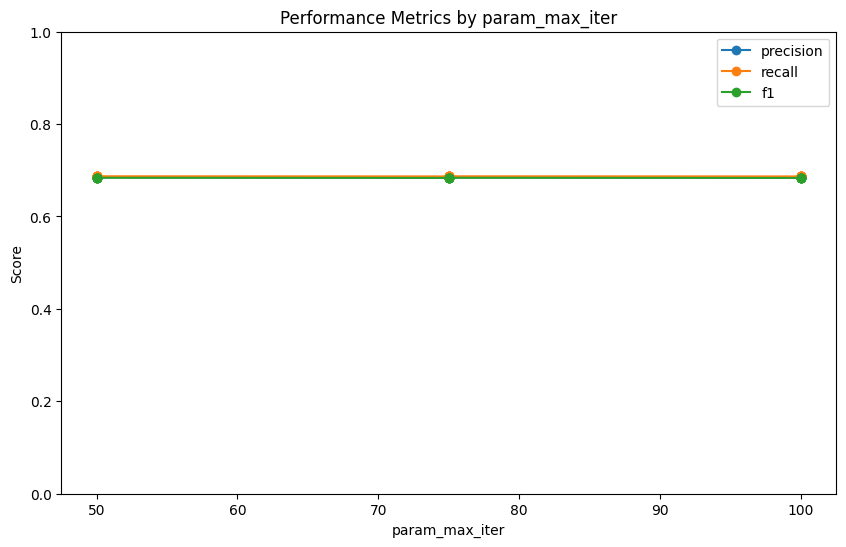

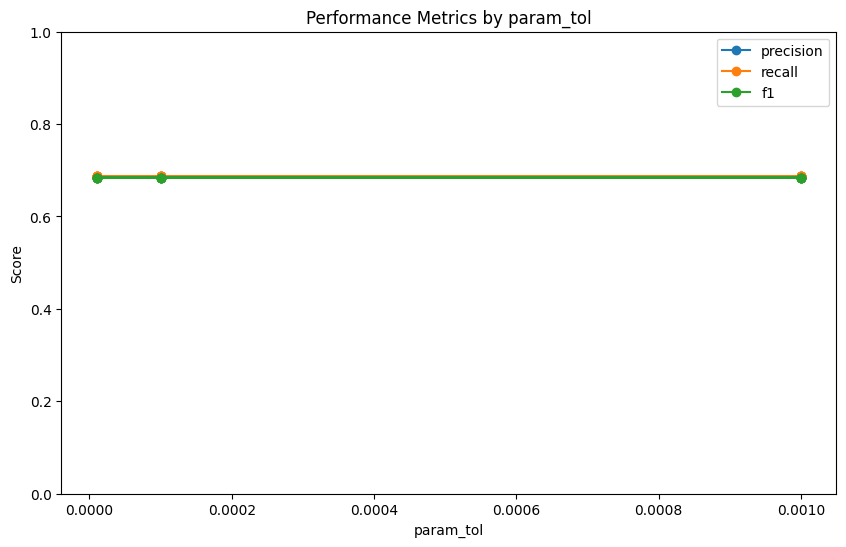

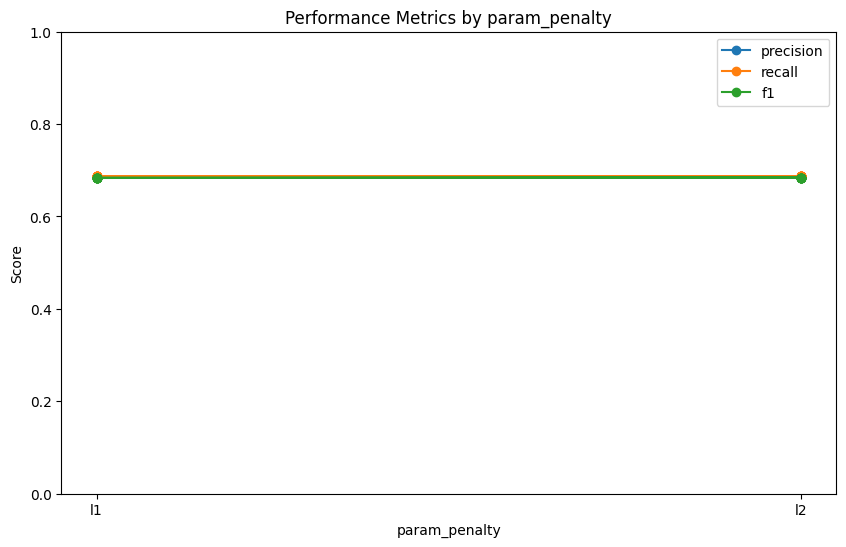


Performance on Validation Set:
Precision: 0.671276173054495
Recall: 0.6720205155891483
F1-score: 0.6655134201151353


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

results = pd.DataFrame(grid_search.cv_results_)

def plot_metrics_by_param(results, param_name, param_values):
    plt.figure(figsize=(10, 6))
    for metric in ['mean_test_precision', 'mean_test_recall', 'mean_test_f1']:
        plt.plot(results[param_name], results[metric], marker='o', label=metric.split('_')[-1])
    plt.xlabel(param_name)
    plt.ylabel('Score')
    plt.title(f'Performance Metrics by {param_name}')
    plt.legend()
    plt.ylim(0, 1)
    plt.show()

plot_metrics_by_param(results, 'param_max_iter', param_grid['max_iter'])
plot_metrics_by_param(results, 'param_tol', param_grid['tol'])
plot_metrics_by_param(results, 'param_penalty', param_grid['penalty'])

y_pred = grid_search.best_estimator_.predict(X_valid)
precision = precision_score(y_valid, y_pred, average='weighted')
recall = recall_score(y_valid, y_pred, average='weighted')
f1 = f1_score(y_valid, y_pred, average='weighted')

print("\nPerformance on Validation Set:")
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

8. **Neural Network:**

    In our exploration and tuning of neural networks, we focus on the following hyperparameters:

    - **Single hidden layer, varying the number of nodes**.

        - Start with a single node in the hidden layer. Use a graph to depict the progression of loss and accuracy for both the training and validation sets, with the horizontal axis representing the number of training epochs and the vertical axis showing loss and accuracy. Training this network should be relatively fast, so let's conduct training for 50 epochs. Observing the graph, what do you conclude? Is the network underfitting or overfitting? Why?

        - Repeat the above process using 2 and 4 nodes in the hidden layer. Use the same type of graph to document your observations regarding loss and accuracy.

        - Start with 8 nodes in the hidden layer and progressively double the number of nodes until it surpasses the number of nodes in the input layer. This results in seven experiments and corresponding graphs for the following configurations: 8, 16, 32, 64, 128, 256, and 512 nodes. Document your observations throughout the process.
        
        - Ensure that the **number of training epochs** is adequate for **observing an increase in validation loss**. **Tip**: During model development, start with a small number of epochs, such as 5 or 10. Once the model appears to perform well, test with larger values, like 40 or 80 epochs, which proved reasonable in our tests. Based on your observations, consider conducting further experiments, if needed. How many epochs were ultimately necessary?

Training model with 1 hidden nodes.
Epoch 1/10
1822/1822 - 3s - loss: 0.6392 - accuracy: 0.4098 - val_loss: 0.6276 - val_accuracy: 0.4108 - 3s/epoch - 2ms/step
Epoch 2/10
1822/1822 - 2s - loss: 0.5695 - accuracy: 0.5618 - val_loss: 0.5349 - val_accuracy: 0.6060 - 2s/epoch - 1ms/step
Epoch 3/10
1822/1822 - 3s - loss: 0.5235 - accuracy: 0.6166 - val_loss: 0.5174 - val_accuracy: 0.6121 - 3s/epoch - 1ms/step
Epoch 4/10
1822/1822 - 3s - loss: 0.5155 - accuracy: 0.6204 - val_loss: 0.5122 - val_accuracy: 0.6169 - 3s/epoch - 1ms/step
Epoch 5/10
1822/1822 - 3s - loss: 0.5131 - accuracy: 0.6219 - val_loss: 0.5082 - val_accuracy: 0.6208 - 3s/epoch - 1ms/step
Epoch 6/10
1822/1822 - 3s - loss: 0.5122 - accuracy: 0.6212 - val_loss: 0.5061 - val_accuracy: 0.6215 - 3s/epoch - 1ms/step
Epoch 7/10
1822/1822 - 3s - loss: 0.5118 - accuracy: 0.6217 - val_loss: 0.5085 - val_accuracy: 0.6168 - 3s/epoch - 1ms/step
Epoch 8/10
1822/1822 - 3s - loss: 0.5115 - accuracy: 0.6212 - val_loss: 0.5053 - val_accuracy: 0

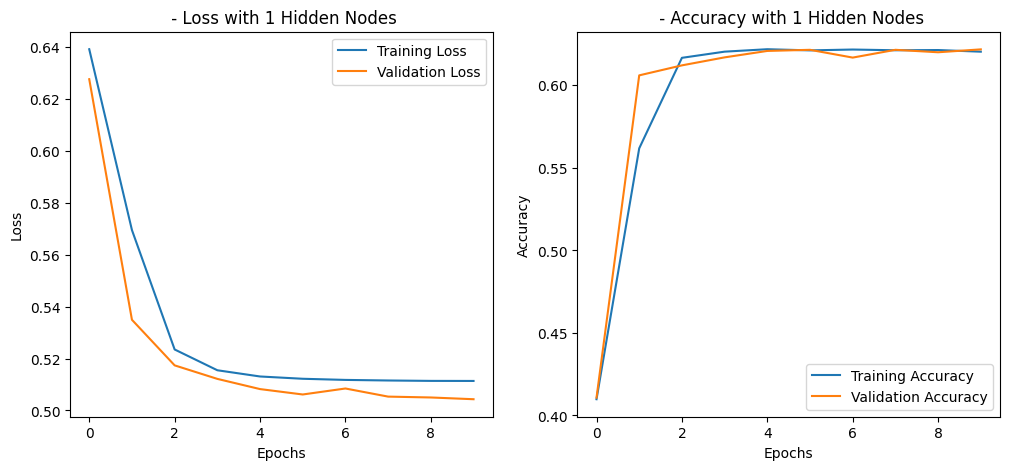

Original Model
Epoch 1/10
1822/1822 - 3s - loss: 0.5114 - accuracy: 0.6202 - val_loss: 0.5073 - val_accuracy: 0.6160 - 3s/epoch - 2ms/step
Epoch 2/10
1822/1822 - 3s - loss: 0.5113 - accuracy: 0.6209 - val_loss: 0.5042 - val_accuracy: 0.6208 - 3s/epoch - 1ms/step
Epoch 3/10
1822/1822 - 3s - loss: 0.5112 - accuracy: 0.6211 - val_loss: 0.5043 - val_accuracy: 0.6203 - 3s/epoch - 2ms/step
Epoch 4/10
1822/1822 - 3s - loss: 0.5111 - accuracy: 0.6204 - val_loss: 0.5036 - val_accuracy: 0.6200 - 3s/epoch - 2ms/step
Epoch 5/10
1822/1822 - 3s - loss: 0.5112 - accuracy: 0.6206 - val_loss: 0.5042 - val_accuracy: 0.6202 - 3s/epoch - 2ms/step
Epoch 6/10
1822/1822 - 3s - loss: 0.5111 - accuracy: 0.6207 - val_loss: 0.5033 - val_accuracy: 0.6210 - 3s/epoch - 1ms/step
Epoch 7/10
1822/1822 - 3s - loss: 0.5110 - accuracy: 0.6207 - val_loss: 0.5041 - val_accuracy: 0.6200 - 3s/epoch - 2ms/step
Epoch 8/10
1822/1822 - 3s - loss: 0.5111 - accuracy: 0.6206 - val_loss: 0.5037 - val_accuracy: 0.6202 - 3s/epoch - 1m

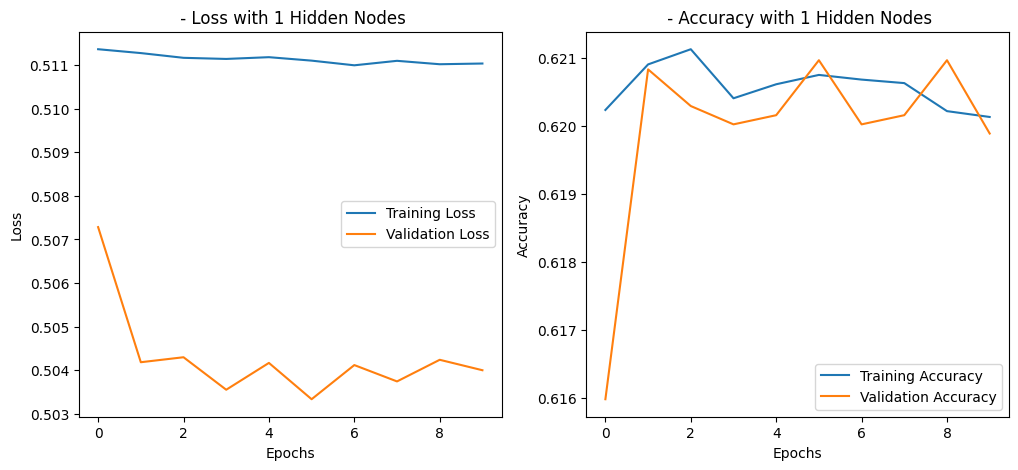

Scaled model
Training model with 2 hidden nodes.
Epoch 1/10
1822/1822 - 4s - loss: 0.5840 - accuracy: 0.5392 - val_loss: 0.5100 - val_accuracy: 0.6574 - 4s/epoch - 2ms/step
Epoch 2/10
1822/1822 - 3s - loss: 0.4809 - accuracy: 0.6792 - val_loss: 0.4474 - val_accuracy: 0.7135 - 3s/epoch - 2ms/step
Epoch 3/10
1822/1822 - 3s - loss: 0.4568 - accuracy: 0.6906 - val_loss: 0.4382 - val_accuracy: 0.7129 - 3s/epoch - 2ms/step
Epoch 4/10
1822/1822 - 3s - loss: 0.4524 - accuracy: 0.6914 - val_loss: 0.4354 - val_accuracy: 0.7143 - 3s/epoch - 2ms/step
Epoch 5/10
1822/1822 - 3s - loss: 0.4510 - accuracy: 0.6918 - val_loss: 0.4362 - val_accuracy: 0.7094 - 3s/epoch - 2ms/step
Epoch 6/10
1822/1822 - 3s - loss: 0.4503 - accuracy: 0.6918 - val_loss: 0.4340 - val_accuracy: 0.7133 - 3s/epoch - 1ms/step
Epoch 7/10
1822/1822 - 3s - loss: 0.4499 - accuracy: 0.6922 - val_loss: 0.4350 - val_accuracy: 0.7090 - 3s/epoch - 2ms/step
Epoch 8/10
1822/1822 - 3s - loss: 0.4496 - accuracy: 0.6915 - val_loss: 0.4328 - va

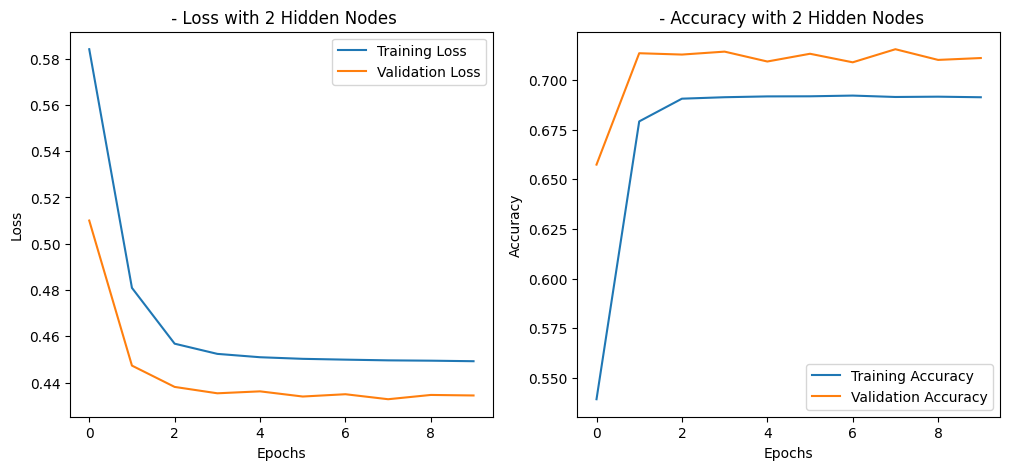

Original Model
Epoch 1/10
1822/1822 - 3s - loss: 0.4491 - accuracy: 0.6909 - val_loss: 0.4386 - val_accuracy: 0.7092 - 3s/epoch - 1ms/step
Epoch 2/10
1822/1822 - 3s - loss: 0.4490 - accuracy: 0.6919 - val_loss: 0.4393 - val_accuracy: 0.7056 - 3s/epoch - 1ms/step
Epoch 3/10
1822/1822 - 3s - loss: 0.4489 - accuracy: 0.6906 - val_loss: 0.4375 - val_accuracy: 0.7100 - 3s/epoch - 2ms/step
Epoch 4/10
1822/1822 - 3s - loss: 0.4488 - accuracy: 0.6906 - val_loss: 0.4368 - val_accuracy: 0.7090 - 3s/epoch - 2ms/step
Epoch 5/10
1822/1822 - 3s - loss: 0.4486 - accuracy: 0.6914 - val_loss: 0.4365 - val_accuracy: 0.7117 - 3s/epoch - 2ms/step
Epoch 6/10
1822/1822 - 3s - loss: 0.4484 - accuracy: 0.6915 - val_loss: 0.4369 - val_accuracy: 0.7102 - 3s/epoch - 2ms/step
Epoch 7/10
1822/1822 - 3s - loss: 0.4483 - accuracy: 0.6899 - val_loss: 0.4368 - val_accuracy: 0.7117 - 3s/epoch - 2ms/step
Epoch 8/10
1822/1822 - 3s - loss: 0.4482 - accuracy: 0.6913 - val_loss: 0.4392 - val_accuracy: 0.7076 - 3s/epoch - 2m

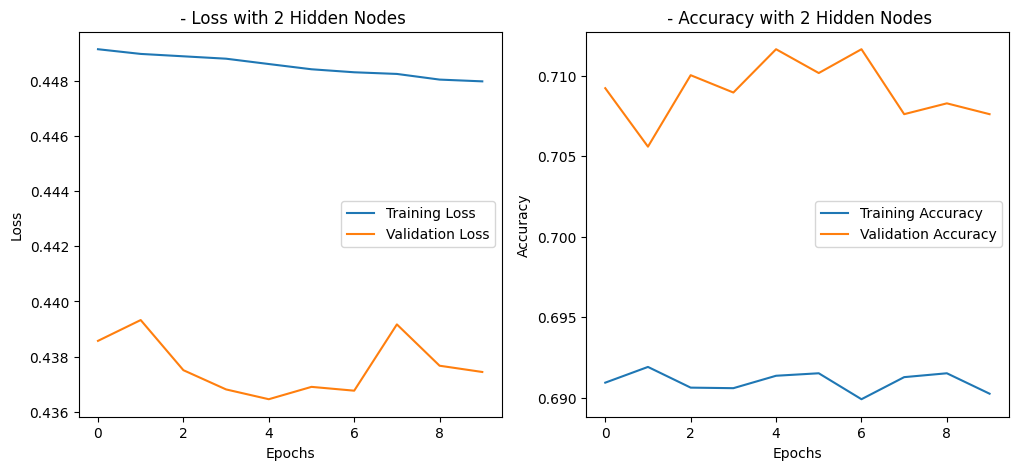

Scaled model
Training model with 4 hidden nodes.
Epoch 1/10
1822/1822 - 4s - loss: 0.5697 - accuracy: 0.5409 - val_loss: 0.4901 - val_accuracy: 0.6772 - 4s/epoch - 2ms/step
Epoch 2/10
1822/1822 - 3s - loss: 0.4745 - accuracy: 0.6770 - val_loss: 0.4367 - val_accuracy: 0.7118 - 3s/epoch - 1ms/step
Epoch 3/10
1822/1822 - 3s - loss: 0.4506 - accuracy: 0.6893 - val_loss: 0.4272 - val_accuracy: 0.7150 - 3s/epoch - 1ms/step
Epoch 4/10
1822/1822 - 3s - loss: 0.4450 - accuracy: 0.6923 - val_loss: 0.4238 - val_accuracy: 0.7177 - 3s/epoch - 1ms/step
Epoch 5/10
1822/1822 - 3s - loss: 0.4424 - accuracy: 0.6926 - val_loss: 0.4223 - val_accuracy: 0.7168 - 3s/epoch - 2ms/step
Epoch 6/10
1822/1822 - 3s - loss: 0.4403 - accuracy: 0.6946 - val_loss: 0.4246 - val_accuracy: 0.7112 - 3s/epoch - 1ms/step
Epoch 7/10
1822/1822 - 3s - loss: 0.4382 - accuracy: 0.6967 - val_loss: 0.4223 - val_accuracy: 0.7147 - 3s/epoch - 1ms/step
Epoch 8/10
1822/1822 - 3s - loss: 0.4366 - accuracy: 0.6976 - val_loss: 0.4214 - va

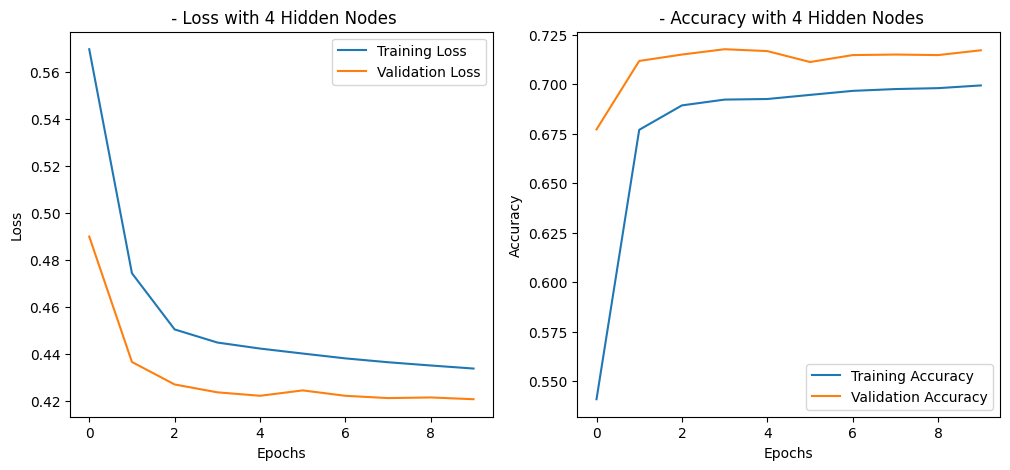

Original Model
Epoch 1/10
1822/1822 - 3s - loss: 0.4329 - accuracy: 0.6999 - val_loss: 0.4270 - val_accuracy: 0.7129 - 3s/epoch - 2ms/step
Epoch 2/10
1822/1822 - 3s - loss: 0.4318 - accuracy: 0.7008 - val_loss: 0.4252 - val_accuracy: 0.7119 - 3s/epoch - 2ms/step
Epoch 3/10
1822/1822 - 3s - loss: 0.4309 - accuracy: 0.7013 - val_loss: 0.4241 - val_accuracy: 0.7141 - 3s/epoch - 2ms/step
Epoch 4/10
1822/1822 - 3s - loss: 0.4301 - accuracy: 0.7020 - val_loss: 0.4260 - val_accuracy: 0.7115 - 3s/epoch - 2ms/step
Epoch 5/10
1822/1822 - 3s - loss: 0.4296 - accuracy: 0.7040 - val_loss: 0.4244 - val_accuracy: 0.7114 - 3s/epoch - 2ms/step
Epoch 6/10
1822/1822 - 3s - loss: 0.4288 - accuracy: 0.7038 - val_loss: 0.4239 - val_accuracy: 0.7143 - 3s/epoch - 2ms/step
Epoch 7/10
1822/1822 - 3s - loss: 0.4284 - accuracy: 0.7050 - val_loss: 0.4236 - val_accuracy: 0.7145 - 3s/epoch - 2ms/step
Epoch 8/10
1822/1822 - 3s - loss: 0.4279 - accuracy: 0.7046 - val_loss: 0.4241 - val_accuracy: 0.7143 - 3s/epoch - 1m

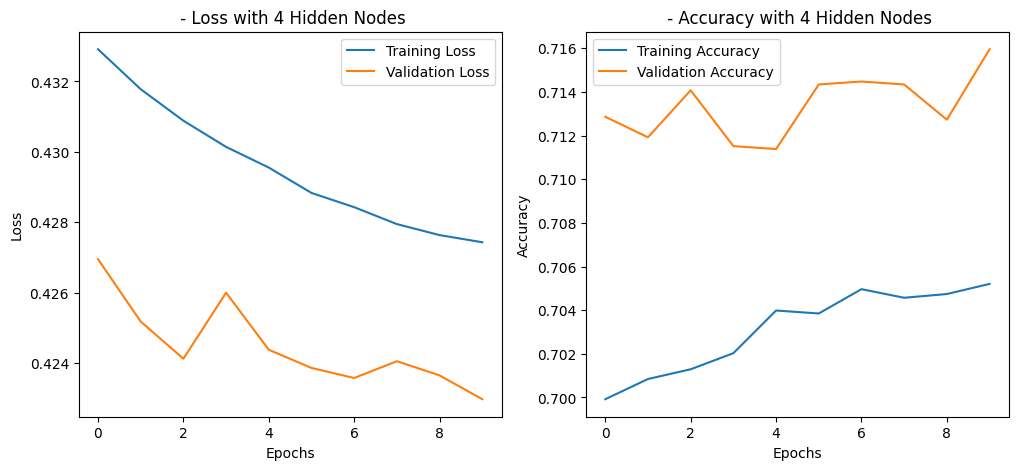

Scaled model
Training model with 8 hidden nodes.
Epoch 1/10
1822/1822 - 4s - loss: 0.4981 - accuracy: 0.6402 - val_loss: 0.4341 - val_accuracy: 0.7102 - 4s/epoch - 2ms/step
Epoch 2/10
1822/1822 - 3s - loss: 0.4493 - accuracy: 0.6891 - val_loss: 0.4279 - val_accuracy: 0.7154 - 3s/epoch - 2ms/step
Epoch 3/10
1822/1822 - 3s - loss: 0.4435 - accuracy: 0.6923 - val_loss: 0.4257 - val_accuracy: 0.7153 - 3s/epoch - 2ms/step
Epoch 4/10
1822/1822 - 3s - loss: 0.4381 - accuracy: 0.6937 - val_loss: 0.4190 - val_accuracy: 0.7189 - 3s/epoch - 2ms/step
Epoch 5/10
1822/1822 - 3s - loss: 0.4341 - accuracy: 0.6959 - val_loss: 0.4180 - val_accuracy: 0.7199 - 3s/epoch - 2ms/step
Epoch 6/10
1822/1822 - 3s - loss: 0.4312 - accuracy: 0.6976 - val_loss: 0.4185 - val_accuracy: 0.7169 - 3s/epoch - 2ms/step
Epoch 7/10
1822/1822 - 3s - loss: 0.4293 - accuracy: 0.6992 - val_loss: 0.4159 - val_accuracy: 0.7197 - 3s/epoch - 2ms/step
Epoch 8/10
1822/1822 - 3s - loss: 0.4273 - accuracy: 0.7011 - val_loss: 0.4148 - va

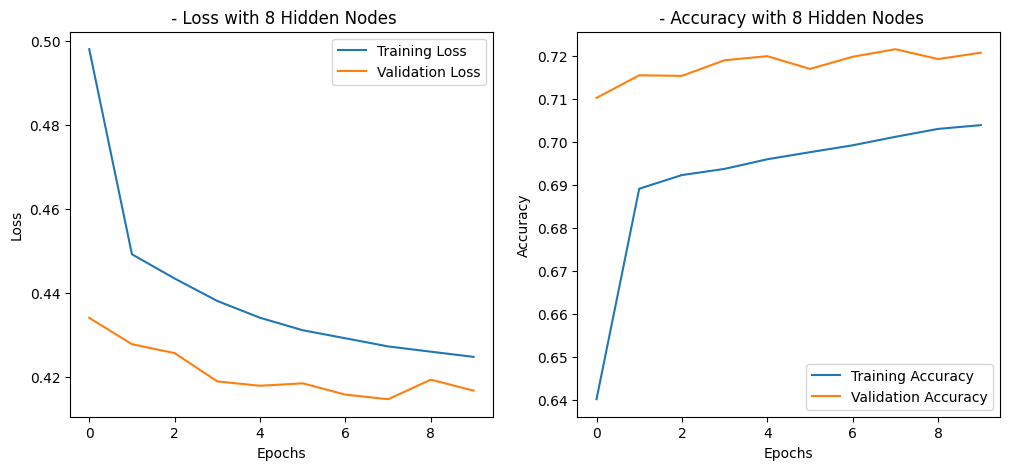

Original Model
Epoch 1/10
1822/1822 - 3s - loss: 0.4238 - accuracy: 0.7049 - val_loss: 0.4206 - val_accuracy: 0.7160 - 3s/epoch - 2ms/step
Epoch 2/10
1822/1822 - 3s - loss: 0.4228 - accuracy: 0.7055 - val_loss: 0.4185 - val_accuracy: 0.7168 - 3s/epoch - 2ms/step
Epoch 3/10
1822/1822 - 3s - loss: 0.4219 - accuracy: 0.7069 - val_loss: 0.4185 - val_accuracy: 0.7161 - 3s/epoch - 2ms/step
Epoch 4/10
1822/1822 - 3s - loss: 0.4211 - accuracy: 0.7083 - val_loss: 0.4181 - val_accuracy: 0.7178 - 3s/epoch - 2ms/step
Epoch 5/10
1822/1822 - 3s - loss: 0.4205 - accuracy: 0.7088 - val_loss: 0.4170 - val_accuracy: 0.7197 - 3s/epoch - 2ms/step
Epoch 6/10
1822/1822 - 3s - loss: 0.4198 - accuracy: 0.7095 - val_loss: 0.4187 - val_accuracy: 0.7153 - 3s/epoch - 2ms/step
Epoch 7/10
1822/1822 - 3s - loss: 0.4192 - accuracy: 0.7110 - val_loss: 0.4188 - val_accuracy: 0.7173 - 3s/epoch - 2ms/step
Epoch 8/10
1822/1822 - 3s - loss: 0.4185 - accuracy: 0.7113 - val_loss: 0.4178 - val_accuracy: 0.7181 - 3s/epoch - 2m

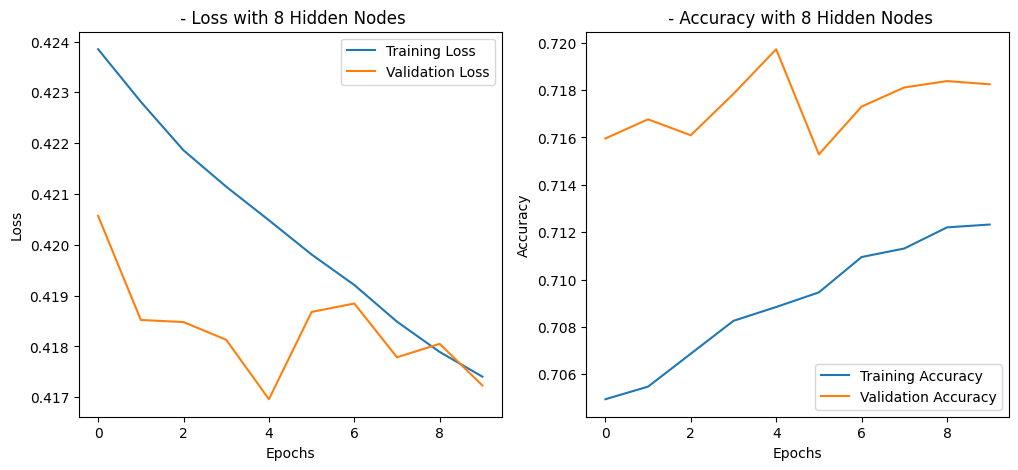

Scaled model
Training model with 16 hidden nodes.
Epoch 1/10
1822/1822 - 4s - loss: 0.4813 - accuracy: 0.6537 - val_loss: 0.4278 - val_accuracy: 0.7145 - 4s/epoch - 2ms/step
Epoch 2/10
1822/1822 - 3s - loss: 0.4428 - accuracy: 0.6901 - val_loss: 0.4218 - val_accuracy: 0.7146 - 3s/epoch - 2ms/step
Epoch 3/10
1822/1822 - 3s - loss: 0.4370 - accuracy: 0.6931 - val_loss: 0.4183 - val_accuracy: 0.7186 - 3s/epoch - 2ms/step
Epoch 4/10
1822/1822 - 3s - loss: 0.4313 - accuracy: 0.6996 - val_loss: 0.4143 - val_accuracy: 0.7219 - 3s/epoch - 2ms/step
Epoch 5/10
1822/1822 - 3s - loss: 0.4240 - accuracy: 0.7066 - val_loss: 0.4091 - val_accuracy: 0.7278 - 3s/epoch - 2ms/step
Epoch 6/10
1822/1822 - 3s - loss: 0.4164 - accuracy: 0.7130 - val_loss: 0.4029 - val_accuracy: 0.7294 - 3s/epoch - 2ms/step
Epoch 7/10
1822/1822 - 3s - loss: 0.4096 - accuracy: 0.7193 - val_loss: 0.3994 - val_accuracy: 0.7334 - 3s/epoch - 2ms/step
Epoch 8/10
1822/1822 - 3s - loss: 0.4038 - accuracy: 0.7253 - val_loss: 0.3999 - v

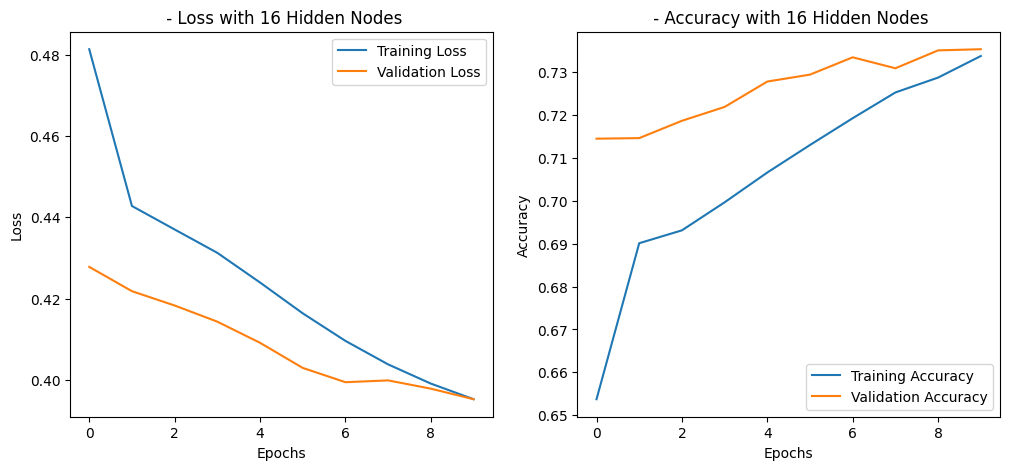

Original Model
Epoch 1/10
1822/1822 - 3s - loss: 0.3917 - accuracy: 0.7350 - val_loss: 0.4017 - val_accuracy: 0.7314 - 3s/epoch - 2ms/step
Epoch 2/10
1822/1822 - 3s - loss: 0.3884 - accuracy: 0.7404 - val_loss: 0.4026 - val_accuracy: 0.7308 - 3s/epoch - 2ms/step
Epoch 3/10
1822/1822 - 3s - loss: 0.3859 - accuracy: 0.7409 - val_loss: 0.4010 - val_accuracy: 0.7314 - 3s/epoch - 2ms/step
Epoch 4/10
1822/1822 - 3s - loss: 0.3838 - accuracy: 0.7448 - val_loss: 0.4014 - val_accuracy: 0.7297 - 3s/epoch - 1ms/step
Epoch 5/10
1822/1822 - 3s - loss: 0.3818 - accuracy: 0.7463 - val_loss: 0.4025 - val_accuracy: 0.7318 - 3s/epoch - 2ms/step
Epoch 6/10
1822/1822 - 3s - loss: 0.3801 - accuracy: 0.7480 - val_loss: 0.4025 - val_accuracy: 0.7309 - 3s/epoch - 2ms/step
Epoch 7/10
1822/1822 - 3s - loss: 0.3788 - accuracy: 0.7488 - val_loss: 0.4040 - val_accuracy: 0.7297 - 3s/epoch - 2ms/step
Epoch 8/10
1822/1822 - 3s - loss: 0.3773 - accuracy: 0.7507 - val_loss: 0.4050 - val_accuracy: 0.7282 - 3s/epoch - 2m

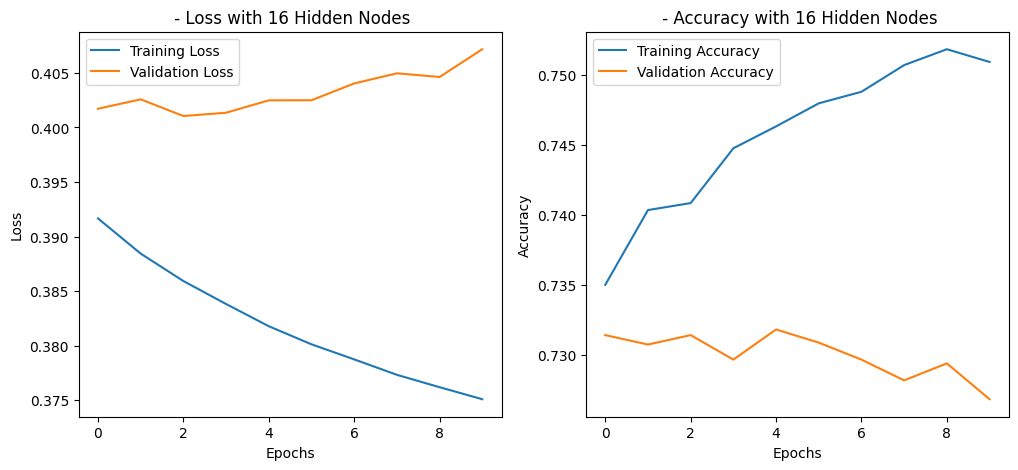

Scaled model
Training model with 32 hidden nodes.
Epoch 1/10
1822/1822 - 4s - loss: 0.4745 - accuracy: 0.6648 - val_loss: 0.4263 - val_accuracy: 0.7138 - 4s/epoch - 2ms/step
Epoch 2/10
1822/1822 - 3s - loss: 0.4392 - accuracy: 0.6933 - val_loss: 0.4142 - val_accuracy: 0.7213 - 3s/epoch - 2ms/step
Epoch 3/10
1822/1822 - 3s - loss: 0.4284 - accuracy: 0.7025 - val_loss: 0.4085 - val_accuracy: 0.7242 - 3s/epoch - 2ms/step
Epoch 4/10
1822/1822 - 3s - loss: 0.4188 - accuracy: 0.7115 - val_loss: 0.4048 - val_accuracy: 0.7326 - 3s/epoch - 2ms/step
Epoch 5/10
1822/1822 - 3s - loss: 0.4089 - accuracy: 0.7212 - val_loss: 0.3993 - val_accuracy: 0.7324 - 3s/epoch - 2ms/step
Epoch 6/10
1822/1822 - 3s - loss: 0.4005 - accuracy: 0.7291 - val_loss: 0.3960 - val_accuracy: 0.7347 - 3s/epoch - 2ms/step
Epoch 7/10
1822/1822 - 3s - loss: 0.3934 - accuracy: 0.7348 - val_loss: 0.3947 - val_accuracy: 0.7330 - 3s/epoch - 2ms/step
Epoch 8/10
1822/1822 - 3s - loss: 0.3865 - accuracy: 0.7416 - val_loss: 0.3972 - v

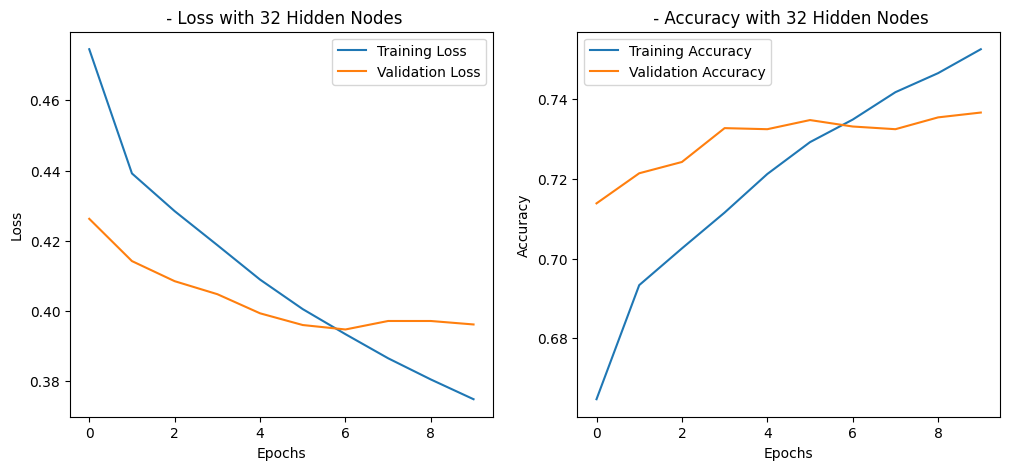

Original Model
Epoch 1/10
1822/1822 - 3s - loss: 0.3690 - accuracy: 0.7578 - val_loss: 0.4036 - val_accuracy: 0.7322 - 3s/epoch - 2ms/step
Epoch 2/10
1822/1822 - 3s - loss: 0.3642 - accuracy: 0.7613 - val_loss: 0.4067 - val_accuracy: 0.7301 - 3s/epoch - 2ms/step
Epoch 3/10
1822/1822 - 3s - loss: 0.3595 - accuracy: 0.7651 - val_loss: 0.4102 - val_accuracy: 0.7316 - 3s/epoch - 2ms/step
Epoch 4/10
1822/1822 - 3s - loss: 0.3551 - accuracy: 0.7696 - val_loss: 0.4112 - val_accuracy: 0.7285 - 3s/epoch - 2ms/step
Epoch 5/10
1822/1822 - 3s - loss: 0.3515 - accuracy: 0.7736 - val_loss: 0.4160 - val_accuracy: 0.7283 - 3s/epoch - 2ms/step
Epoch 6/10
1822/1822 - 3s - loss: 0.3479 - accuracy: 0.7774 - val_loss: 0.4170 - val_accuracy: 0.7254 - 3s/epoch - 2ms/step
Epoch 7/10
1822/1822 - 3s - loss: 0.3441 - accuracy: 0.7791 - val_loss: 0.4195 - val_accuracy: 0.7275 - 3s/epoch - 2ms/step
Epoch 8/10
1822/1822 - 3s - loss: 0.3416 - accuracy: 0.7822 - val_loss: 0.4233 - val_accuracy: 0.7259 - 3s/epoch - 2m

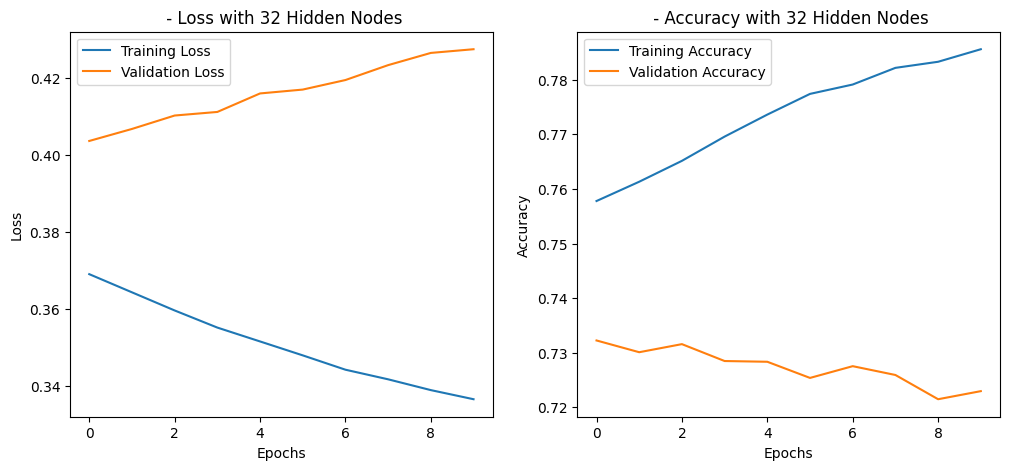

Scaled model
Training model with 64 hidden nodes.
Epoch 1/10
1822/1822 - 4s - loss: 0.4708 - accuracy: 0.6638 - val_loss: 0.4262 - val_accuracy: 0.7135 - 4s/epoch - 2ms/step
Epoch 2/10
1822/1822 - 3s - loss: 0.4385 - accuracy: 0.6927 - val_loss: 0.4174 - val_accuracy: 0.7192 - 3s/epoch - 2ms/step
Epoch 3/10
1822/1822 - 3s - loss: 0.4213 - accuracy: 0.7083 - val_loss: 0.4050 - val_accuracy: 0.7271 - 3s/epoch - 2ms/step
Epoch 4/10
1822/1822 - 3s - loss: 0.4016 - accuracy: 0.7271 - val_loss: 0.3979 - val_accuracy: 0.7344 - 3s/epoch - 2ms/step
Epoch 5/10
1822/1822 - 3s - loss: 0.3830 - accuracy: 0.7444 - val_loss: 0.3961 - val_accuracy: 0.7368 - 3s/epoch - 2ms/step
Epoch 6/10
1822/1822 - 3s - loss: 0.3678 - accuracy: 0.7584 - val_loss: 0.3952 - val_accuracy: 0.7353 - 3s/epoch - 2ms/step
Epoch 7/10
1822/1822 - 3s - loss: 0.3547 - accuracy: 0.7693 - val_loss: 0.3958 - val_accuracy: 0.7407 - 3s/epoch - 2ms/step
Epoch 8/10
1822/1822 - 3s - loss: 0.3433 - accuracy: 0.7794 - val_loss: 0.3997 - v

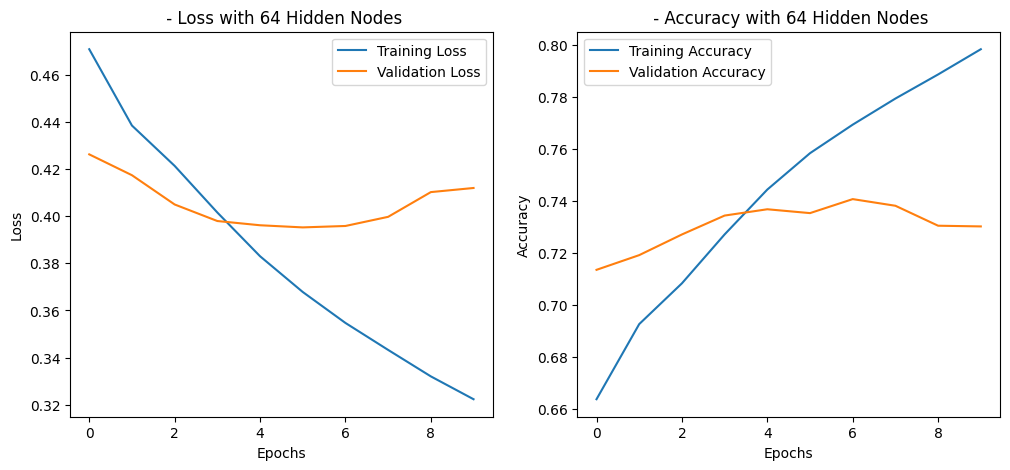

Original Model
Epoch 1/10
1822/1822 - 3s - loss: 0.3127 - accuracy: 0.8059 - val_loss: 0.4295 - val_accuracy: 0.7290 - 3s/epoch - 2ms/step
Epoch 2/10
1822/1822 - 3s - loss: 0.3033 - accuracy: 0.8130 - val_loss: 0.4378 - val_accuracy: 0.7189 - 3s/epoch - 2ms/step
Epoch 3/10
1822/1822 - 3s - loss: 0.2957 - accuracy: 0.8197 - val_loss: 0.4477 - val_accuracy: 0.7205 - 3s/epoch - 2ms/step
Epoch 4/10
1822/1822 - 3s - loss: 0.2880 - accuracy: 0.8250 - val_loss: 0.4552 - val_accuracy: 0.7192 - 3s/epoch - 2ms/step
Epoch 5/10
1822/1822 - 3s - loss: 0.2811 - accuracy: 0.8313 - val_loss: 0.4631 - val_accuracy: 0.7189 - 3s/epoch - 2ms/step
Epoch 6/10
1822/1822 - 3s - loss: 0.2752 - accuracy: 0.8355 - val_loss: 0.4747 - val_accuracy: 0.7154 - 3s/epoch - 2ms/step
Epoch 7/10
1822/1822 - 3s - loss: 0.2697 - accuracy: 0.8416 - val_loss: 0.4816 - val_accuracy: 0.7104 - 3s/epoch - 2ms/step
Epoch 8/10
1822/1822 - 3s - loss: 0.2651 - accuracy: 0.8453 - val_loss: 0.4888 - val_accuracy: 0.7110 - 3s/epoch - 2m

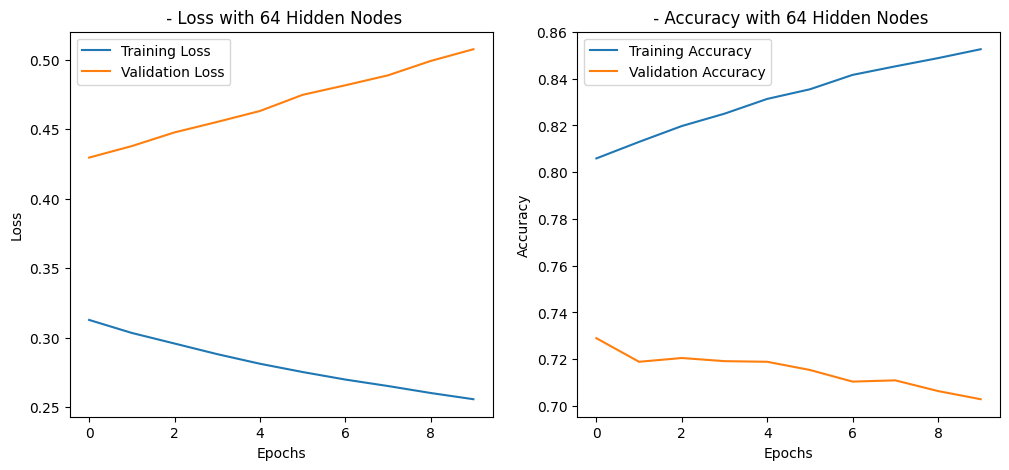

Scaled model
Training model with 128 hidden nodes.
Epoch 1/10
1822/1822 - 5s - loss: 0.4661 - accuracy: 0.6689 - val_loss: 0.4215 - val_accuracy: 0.7152 - 5s/epoch - 3ms/step
Epoch 2/10
1822/1822 - 4s - loss: 0.4274 - accuracy: 0.7038 - val_loss: 0.4059 - val_accuracy: 0.7291 - 4s/epoch - 2ms/step
Epoch 3/10
1822/1822 - 4s - loss: 0.4001 - accuracy: 0.7298 - val_loss: 0.3954 - val_accuracy: 0.7340 - 4s/epoch - 2ms/step
Epoch 4/10
1822/1822 - 4s - loss: 0.3773 - accuracy: 0.7498 - val_loss: 0.3914 - val_accuracy: 0.7380 - 4s/epoch - 2ms/step
Epoch 5/10
1822/1822 - 4s - loss: 0.3565 - accuracy: 0.7662 - val_loss: 0.3928 - val_accuracy: 0.7361 - 4s/epoch - 2ms/step
Epoch 6/10
1822/1822 - 4s - loss: 0.3351 - accuracy: 0.7862 - val_loss: 0.3961 - val_accuracy: 0.7339 - 4s/epoch - 2ms/step
Epoch 7/10
1822/1822 - 4s - loss: 0.3143 - accuracy: 0.8055 - val_loss: 0.4016 - val_accuracy: 0.7297 - 4s/epoch - 2ms/step
Epoch 8/10
1822/1822 - 4s - loss: 0.2945 - accuracy: 0.8219 - val_loss: 0.4156 - 

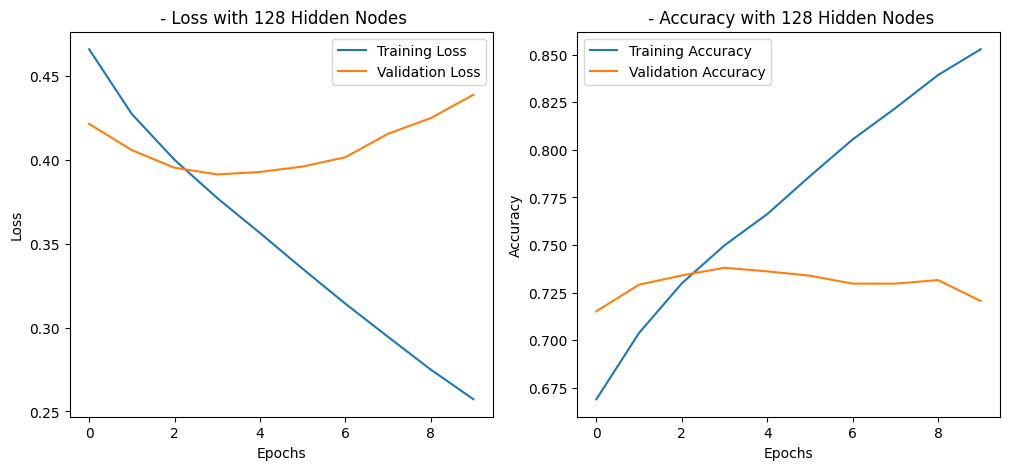

Original Model
Epoch 1/10
1822/1822 - 5s - loss: 0.2408 - accuracy: 0.8662 - val_loss: 0.4561 - val_accuracy: 0.7193 - 5s/epoch - 2ms/step
Epoch 2/10
1822/1822 - 4s - loss: 0.2254 - accuracy: 0.8778 - val_loss: 0.4793 - val_accuracy: 0.7104 - 4s/epoch - 2ms/step
Epoch 3/10
1822/1822 - 4s - loss: 0.2115 - accuracy: 0.8884 - val_loss: 0.5044 - val_accuracy: 0.7084 - 4s/epoch - 2ms/step
Epoch 4/10
1822/1822 - 4s - loss: 0.1990 - accuracy: 0.8975 - val_loss: 0.5144 - val_accuracy: 0.7059 - 4s/epoch - 2ms/step
Epoch 5/10
1822/1822 - 4s - loss: 0.1875 - accuracy: 0.9066 - val_loss: 0.5441 - val_accuracy: 0.7006 - 4s/epoch - 2ms/step
Epoch 6/10
1822/1822 - 4s - loss: 0.1767 - accuracy: 0.9146 - val_loss: 0.5641 - val_accuracy: 0.6989 - 4s/epoch - 2ms/step
Epoch 7/10
1822/1822 - 4s - loss: 0.1676 - accuracy: 0.9206 - val_loss: 0.5784 - val_accuracy: 0.6966 - 4s/epoch - 2ms/step
Epoch 8/10
1822/1822 - 4s - loss: 0.1580 - accuracy: 0.9260 - val_loss: 0.6009 - val_accuracy: 0.6970 - 4s/epoch - 2m

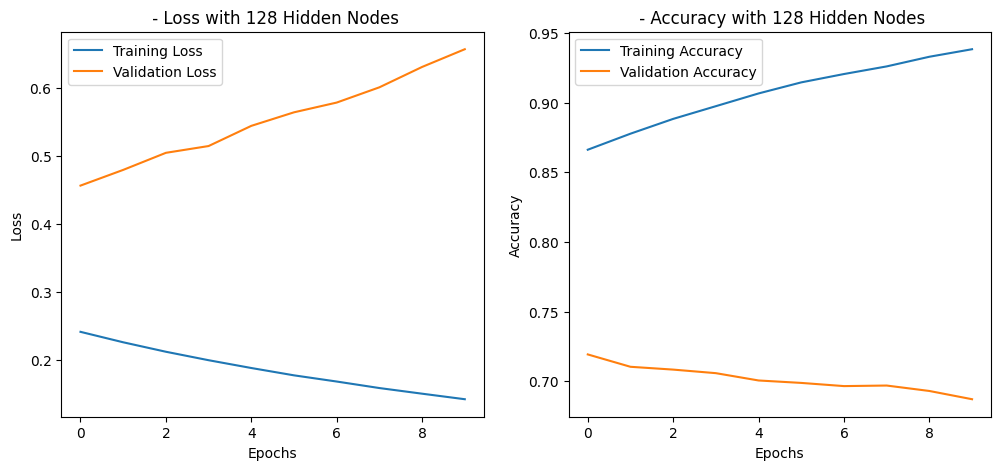

Scaled model
Training model with 256 hidden nodes.
Epoch 1/10
1822/1822 - 6s - loss: 0.4627 - accuracy: 0.6702 - val_loss: 0.4193 - val_accuracy: 0.7161 - 6s/epoch - 3ms/step
Epoch 2/10
1822/1822 - 5s - loss: 0.4180 - accuracy: 0.7119 - val_loss: 0.3983 - val_accuracy: 0.7361 - 5s/epoch - 3ms/step
Epoch 3/10
1822/1822 - 5s - loss: 0.3810 - accuracy: 0.7462 - val_loss: 0.3882 - val_accuracy: 0.7426 - 5s/epoch - 3ms/step
Epoch 4/10
1822/1822 - 5s - loss: 0.3483 - accuracy: 0.7728 - val_loss: 0.3919 - val_accuracy: 0.7353 - 5s/epoch - 3ms/step
Epoch 5/10
1822/1822 - 5s - loss: 0.3146 - accuracy: 0.8039 - val_loss: 0.4008 - val_accuracy: 0.7367 - 5s/epoch - 3ms/step
Epoch 6/10
1822/1822 - 5s - loss: 0.2800 - accuracy: 0.8353 - val_loss: 0.4202 - val_accuracy: 0.7291 - 5s/epoch - 3ms/step
Epoch 7/10
1822/1822 - 5s - loss: 0.2477 - accuracy: 0.8603 - val_loss: 0.4365 - val_accuracy: 0.7220 - 5s/epoch - 3ms/step
Epoch 8/10
1822/1822 - 5s - loss: 0.2179 - accuracy: 0.8821 - val_loss: 0.4554 - 

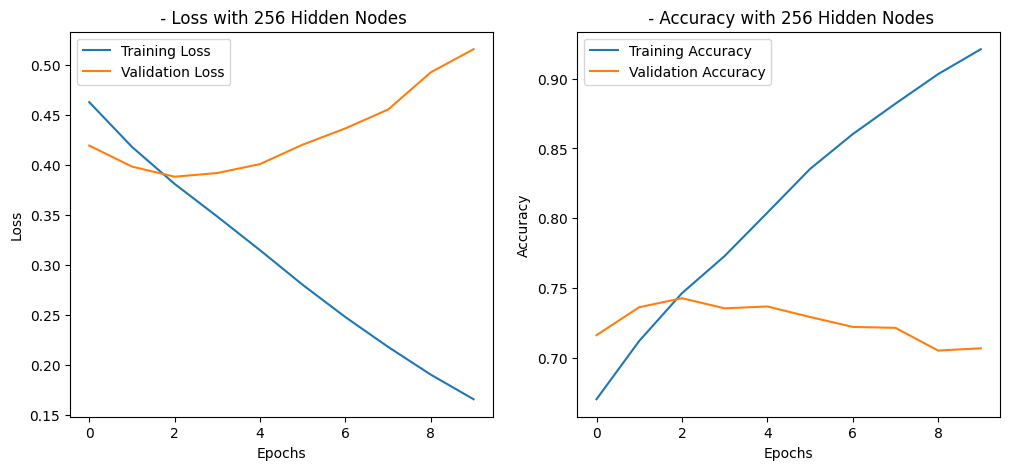

Original Model
Epoch 1/10
1822/1822 - 5s - loss: 0.1432 - accuracy: 0.9365 - val_loss: 0.5640 - val_accuracy: 0.6993 - 5s/epoch - 3ms/step
Epoch 2/10
1822/1822 - 5s - loss: 0.1235 - accuracy: 0.9490 - val_loss: 0.5924 - val_accuracy: 0.6943 - 5s/epoch - 3ms/step
Epoch 3/10
1822/1822 - 5s - loss: 0.1064 - accuracy: 0.9601 - val_loss: 0.6445 - val_accuracy: 0.6942 - 5s/epoch - 3ms/step
Epoch 4/10
1822/1822 - 5s - loss: 0.0913 - accuracy: 0.9696 - val_loss: 0.6750 - val_accuracy: 0.6936 - 5s/epoch - 3ms/step
Epoch 5/10
1822/1822 - 5s - loss: 0.0784 - accuracy: 0.9759 - val_loss: 0.7184 - val_accuracy: 0.6895 - 5s/epoch - 3ms/step
Epoch 6/10
1822/1822 - 5s - loss: 0.0669 - accuracy: 0.9822 - val_loss: 0.7854 - val_accuracy: 0.6892 - 5s/epoch - 3ms/step
Epoch 7/10
1822/1822 - 5s - loss: 0.0573 - accuracy: 0.9874 - val_loss: 0.8056 - val_accuracy: 0.6929 - 5s/epoch - 3ms/step
Epoch 8/10
1822/1822 - 5s - loss: 0.0492 - accuracy: 0.9900 - val_loss: 0.8721 - val_accuracy: 0.6851 - 5s/epoch - 3m

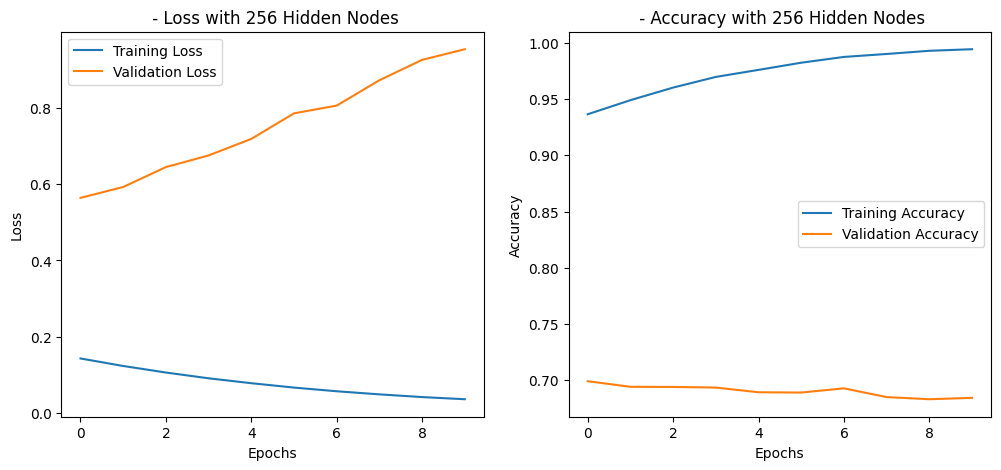

Scaled model
Training model with 512 hidden nodes.
Epoch 1/10
1822/1822 - 7s - loss: 0.4594 - accuracy: 0.6736 - val_loss: 0.4095 - val_accuracy: 0.7226 - 7s/epoch - 4ms/step
Epoch 2/10
1822/1822 - 6s - loss: 0.4064 - accuracy: 0.7240 - val_loss: 0.3895 - val_accuracy: 0.7394 - 6s/epoch - 3ms/step
Epoch 3/10
1822/1822 - 6s - loss: 0.3636 - accuracy: 0.7619 - val_loss: 0.3923 - val_accuracy: 0.7387 - 6s/epoch - 3ms/step
Epoch 4/10
1822/1822 - 6s - loss: 0.3150 - accuracy: 0.8036 - val_loss: 0.3988 - val_accuracy: 0.7355 - 6s/epoch - 3ms/step
Epoch 5/10
1822/1822 - 6s - loss: 0.2622 - accuracy: 0.8483 - val_loss: 0.4209 - val_accuracy: 0.7312 - 6s/epoch - 3ms/step
Epoch 6/10
1822/1822 - 6s - loss: 0.2133 - accuracy: 0.8869 - val_loss: 0.4513 - val_accuracy: 0.7255 - 6s/epoch - 3ms/step
Epoch 7/10
1822/1822 - 6s - loss: 0.1707 - accuracy: 0.9186 - val_loss: 0.4820 - val_accuracy: 0.7230 - 6s/epoch - 3ms/step
Epoch 8/10
1822/1822 - 6s - loss: 0.1339 - accuracy: 0.9435 - val_loss: 0.5437 - 

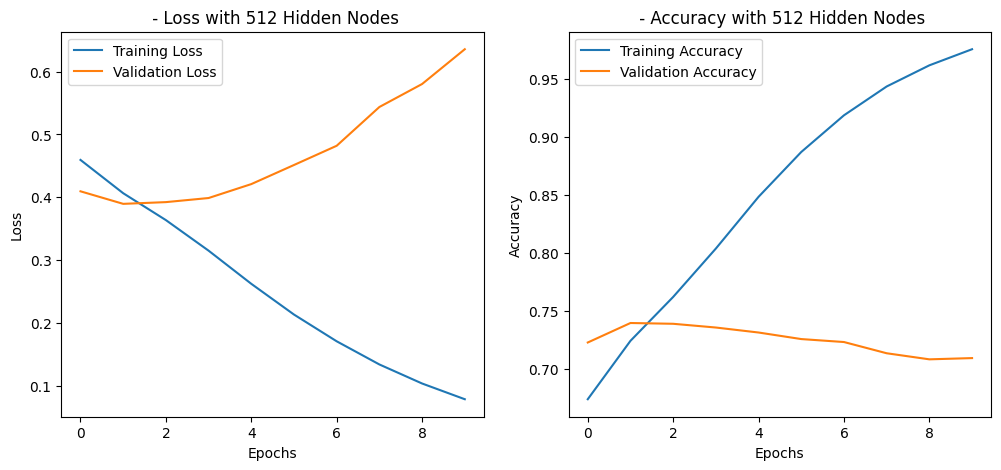

Original Model
Epoch 1/10
1822/1822 - 6s - loss: 0.0597 - accuracy: 0.9851 - val_loss: 0.6971 - val_accuracy: 0.7029 - 6s/epoch - 3ms/step
Epoch 2/10
1822/1822 - 6s - loss: 0.0463 - accuracy: 0.9896 - val_loss: 0.7563 - val_accuracy: 0.7006 - 6s/epoch - 3ms/step
Epoch 3/10
1822/1822 - 6s - loss: 0.0353 - accuracy: 0.9942 - val_loss: 0.8150 - val_accuracy: 0.6960 - 6s/epoch - 3ms/step
Epoch 4/10
1822/1822 - 6s - loss: 0.0281 - accuracy: 0.9962 - val_loss: 0.8677 - val_accuracy: 0.6959 - 6s/epoch - 3ms/step
Epoch 5/10
1822/1822 - 6s - loss: 0.0232 - accuracy: 0.9974 - val_loss: 0.9375 - val_accuracy: 0.6943 - 6s/epoch - 3ms/step
Epoch 6/10
1822/1822 - 6s - loss: 0.0186 - accuracy: 0.9984 - val_loss: 0.9734 - val_accuracy: 0.6907 - 6s/epoch - 3ms/step
Epoch 7/10
1822/1822 - 6s - loss: 0.0163 - accuracy: 0.9985 - val_loss: 1.0266 - val_accuracy: 0.6932 - 6s/epoch - 3ms/step
Epoch 8/10
1822/1822 - 6s - loss: 0.0158 - accuracy: 0.9985 - val_loss: 1.0697 - val_accuracy: 0.6942 - 6s/epoch - 3m

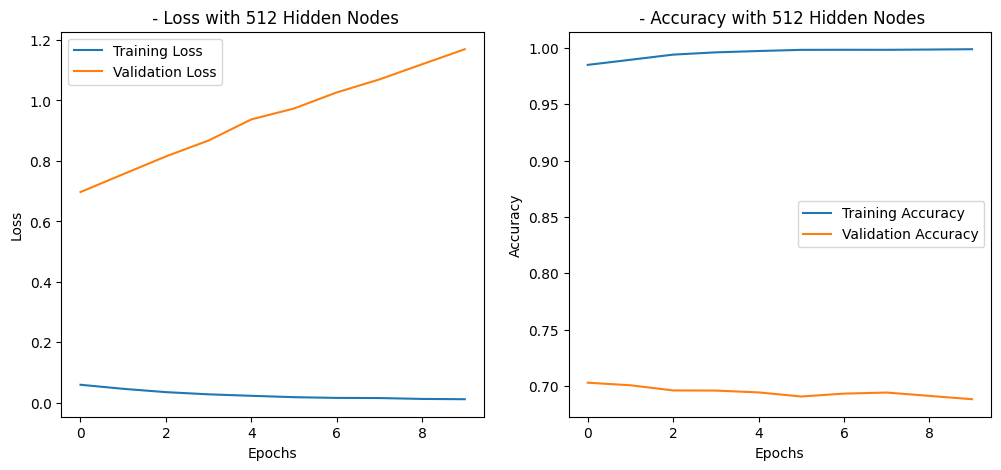

Scaled model


In [21]:
# Code cell
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Function to create and compile a neural network with a single hidden layer
def create_model(input_dim, hidden_units):
    model = Sequential()
    model.add(Dense(hidden_units, activation='relu', input_shape=(input_dim,)))
    model.add(Dense(3, activation='sigmoid'))  # Use 'softmax' for multi-class classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Adjusted function for plotting loss and accuracy with corrected title line
def train_and_plot_model(type, model, X_train, y_train, X_val, y_val, epochs=10, title=""):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val), verbose=2)
    # Plotting training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{title} - Loss with {model.layers[0].units} Hidden Nodes')

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{title} - Accuracy with {model.layers[0].units} Hidden Nodes')
    plt.show()

    if(type ==0):
        print("Original Model")
    else:
        print("Scaled model")



input_dim = X_train.shape[1]

# List of hidden layer nodes to experiment with
hidden_nodes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

# Training and plotting for each configuration
for nodes in hidden_nodes:
    print(f"Training model with {nodes} hidden nodes.")
    model = create_model(input_dim, nodes)
    train_and_plot_model(0,model, X_train, y_train_categorical, X_test, y_test_categorical, epochs=10)
    train_and_plot_model(1,model, X_train_scaled, y_train_scaled_categorical, X_test_scaled, y_test_scaled_categorical, epochs=10)

**8a: Hidden Nodes** <br> 
With each greater input difference the training accuracy lines steadied, meaning there were less fluctuations and the graph resembles a sqrt(x) graph. By doing an analysis of 50 epochs, you can see that the accuracy improved with each epoch iteration. The validation loss grew over time and the training loss diminished. Looking at the scaled data, the graphs were rounded and reached peak accuracy earlier. The accuracy graph resembles a linear relationship with the scaled data. There is obvious overfitting within the scaled data with hidden node count >= 128 as the accuracy is 100% with no fluctuations.


    - **Varying the number of layers**.

        - Conduct similar experiments as described above, but this time vary the number of layers from 1 to 4. Document your findings.

        - How many nodes should each layer contain? Test at least two scenarios. Traditionally, a common strategy involved decreasing the number of nodes from the input layer to the output layer, often by halving, to create a pyramid-like structure. However, recent experience suggests that maintaining a constant number of nodes across all layers can perform equally well. Describe your observations. It is acceptable if both strategies yield similar performance results.

        - Select one your models that exemplifies overfitting. In our experiments, we easily constructed a model achieving nearly 100% accuracy on the training data, yet showing no similar improvement on the validation set. Present this neural network along with its accuracy and loss graphs. Explain the reasoning for concluding that the model is overfitting.

Training model with configuration: Pyramid_1_layer, Layers: [32]


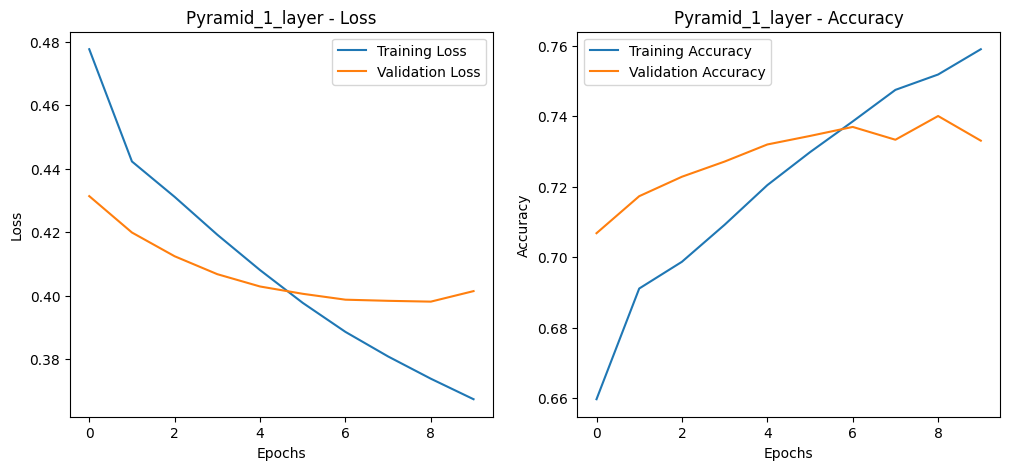

Original Model


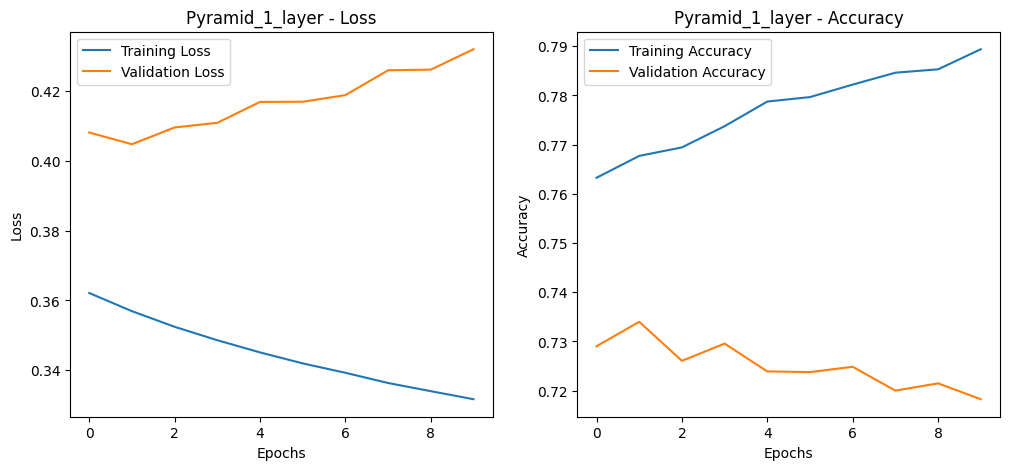

Scaled model
Training model with configuration: Pyramid_2_layers, Layers: [64, 32]


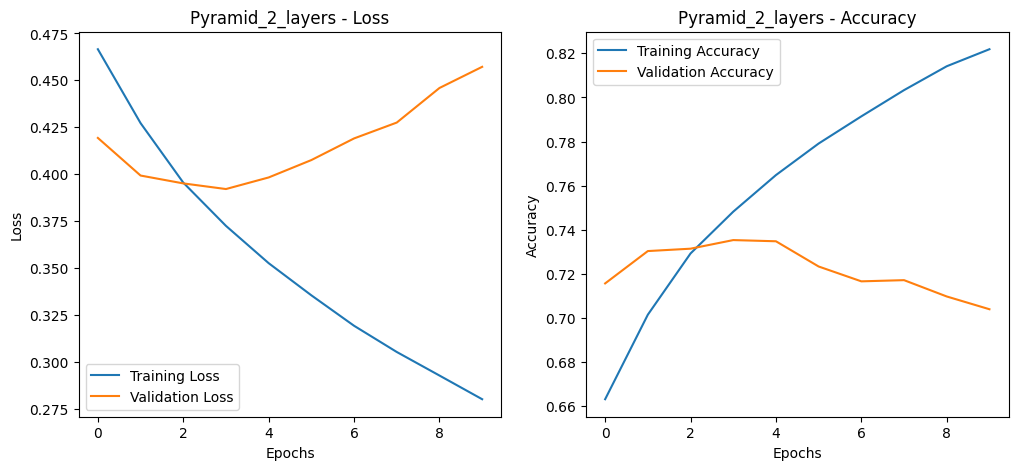

Original Model


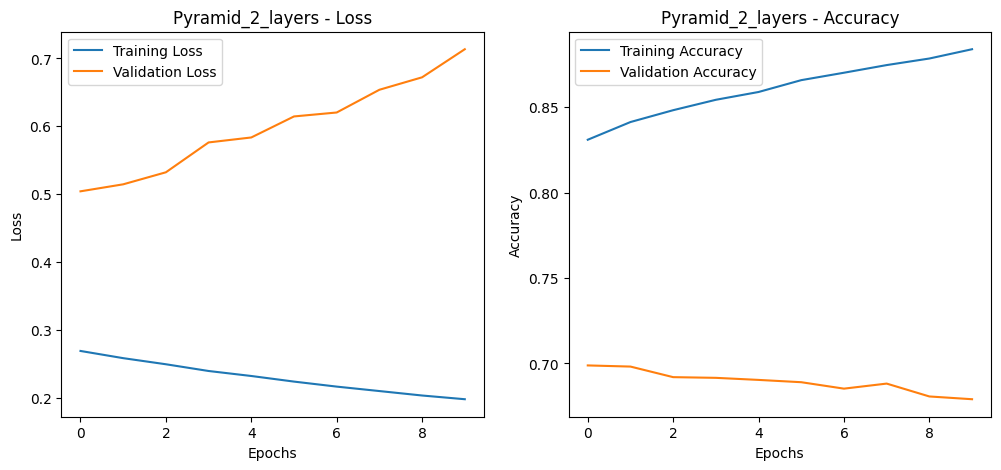

Scaled model
Training model with configuration: Pyramid_3_layers, Layers: [128, 64, 32]


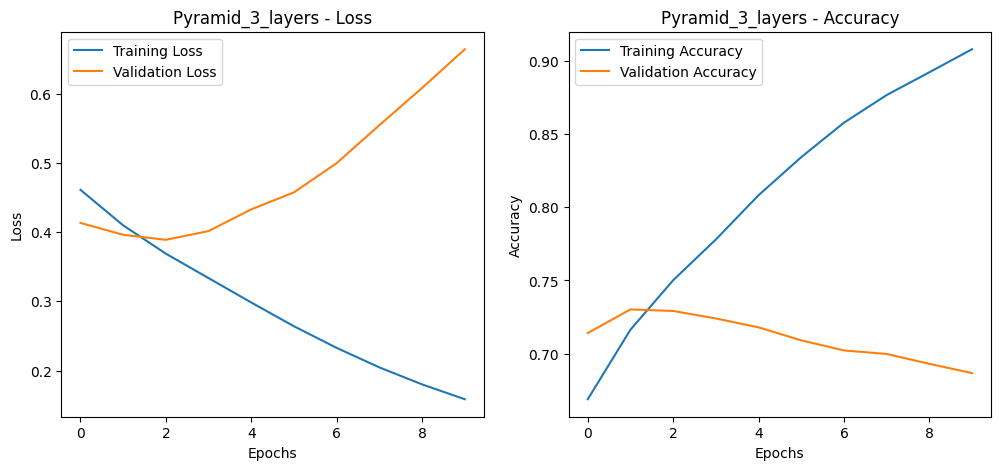

Original Model


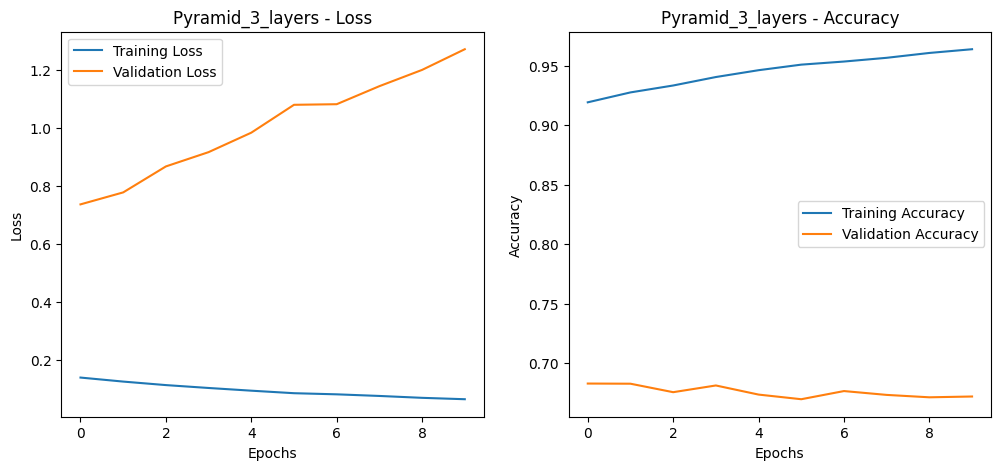

Scaled model
Training model with configuration: Pyramid_4_layers, Layers: [256, 128, 64, 32]


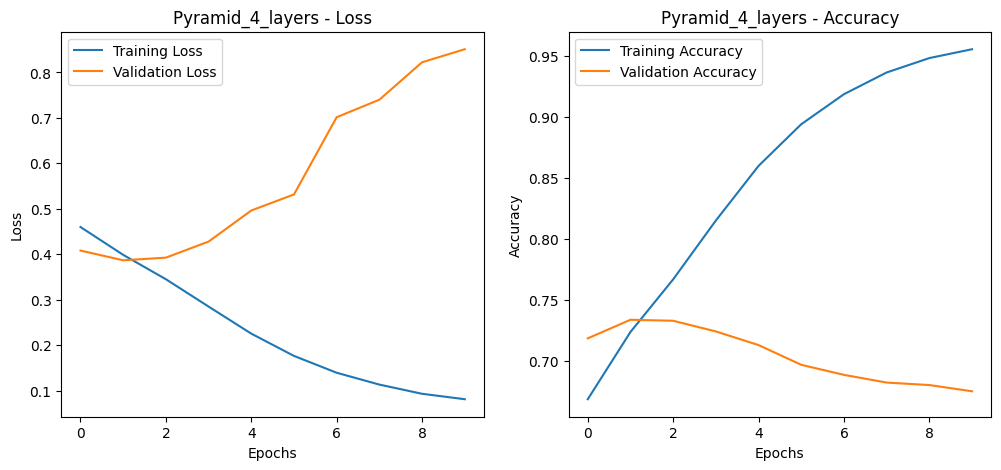

Original Model


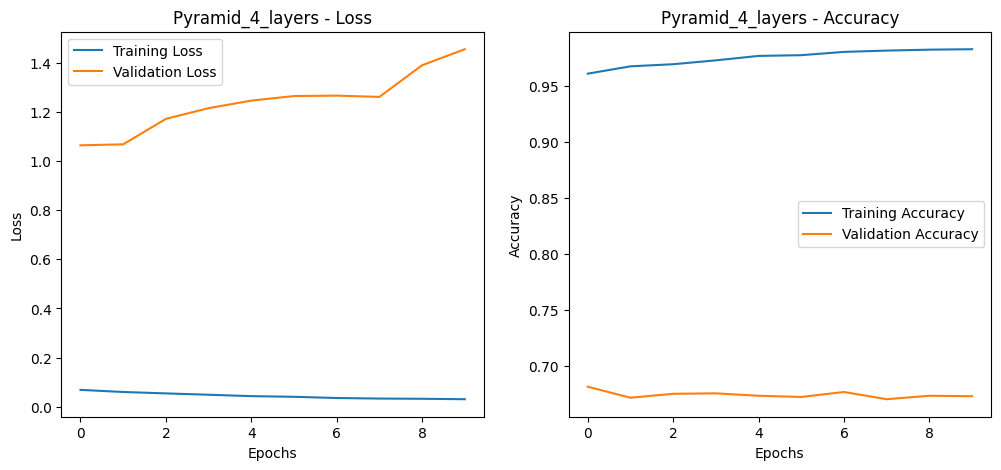

Scaled model
Training model with configuration: Constant_1_layer, Layers: [32]


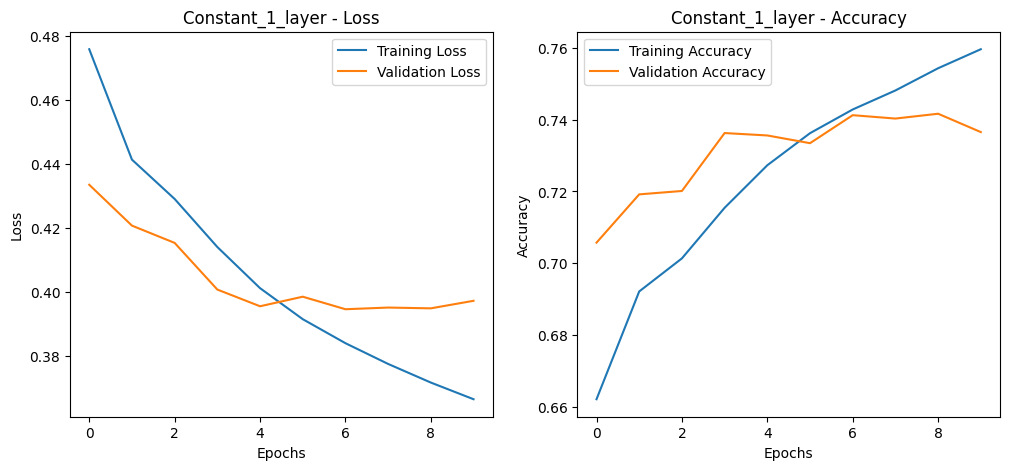

Original Model


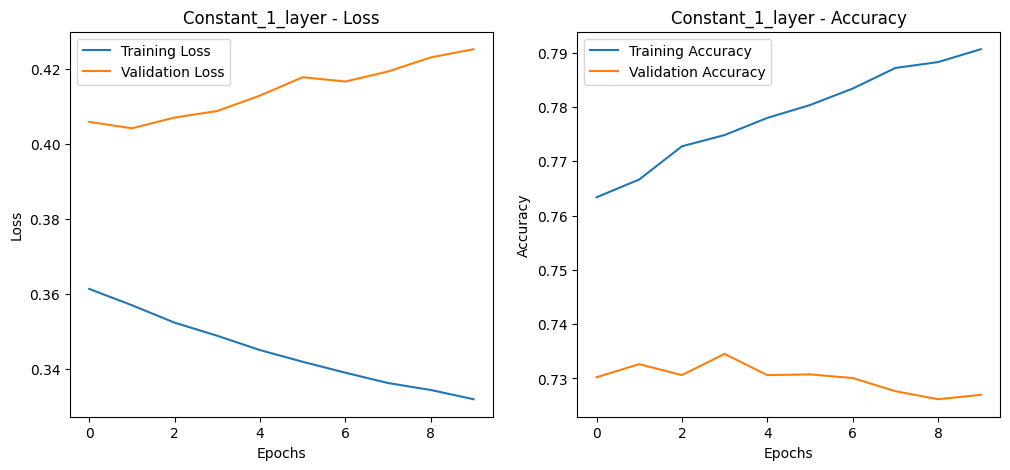

Scaled model
Training model with configuration: Constant_2_layers, Layers: [64, 64]


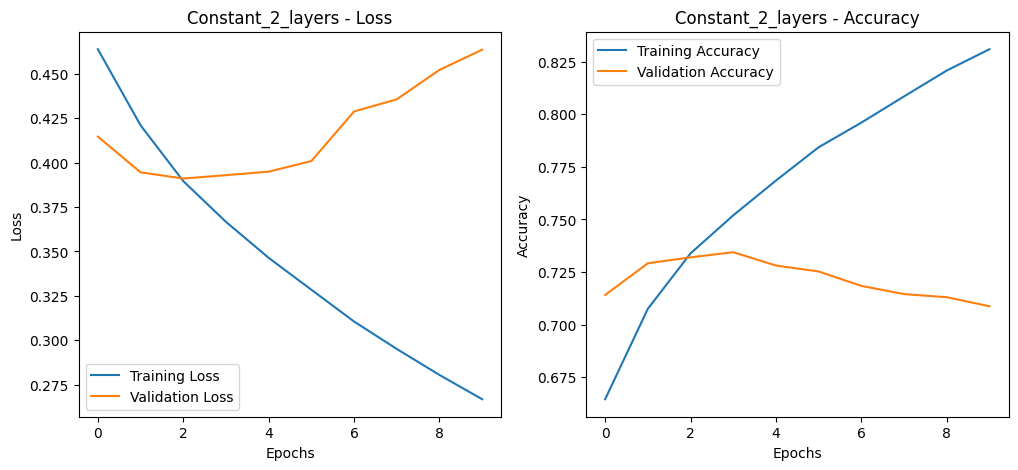

Original Model


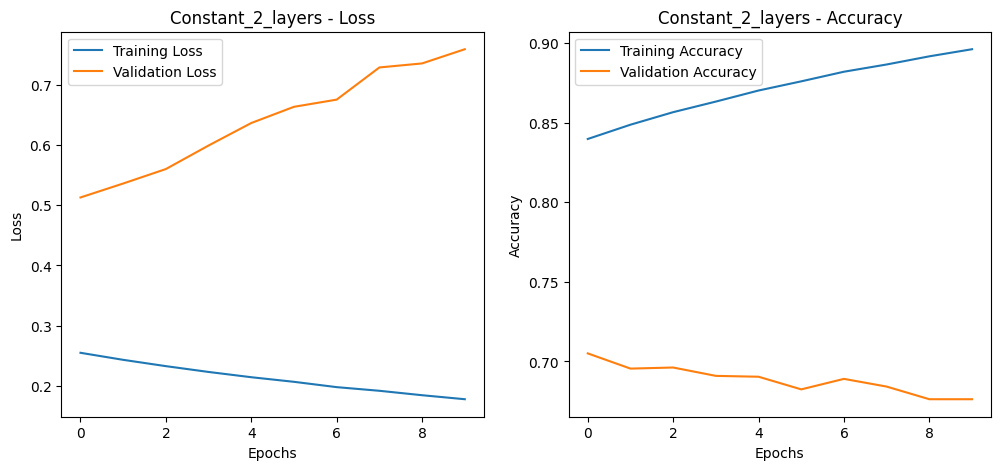

Scaled model
Training model with configuration: Constant_3_layers, Layers: [128, 128, 128]


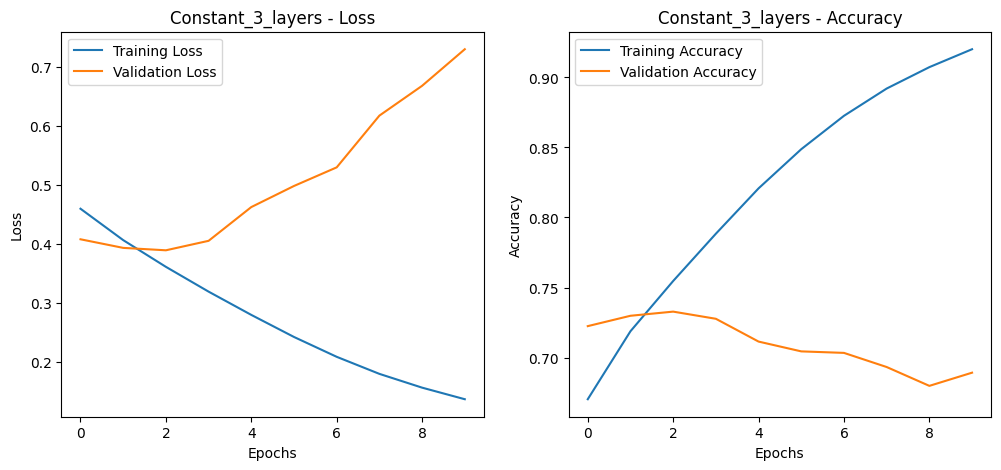

Original Model


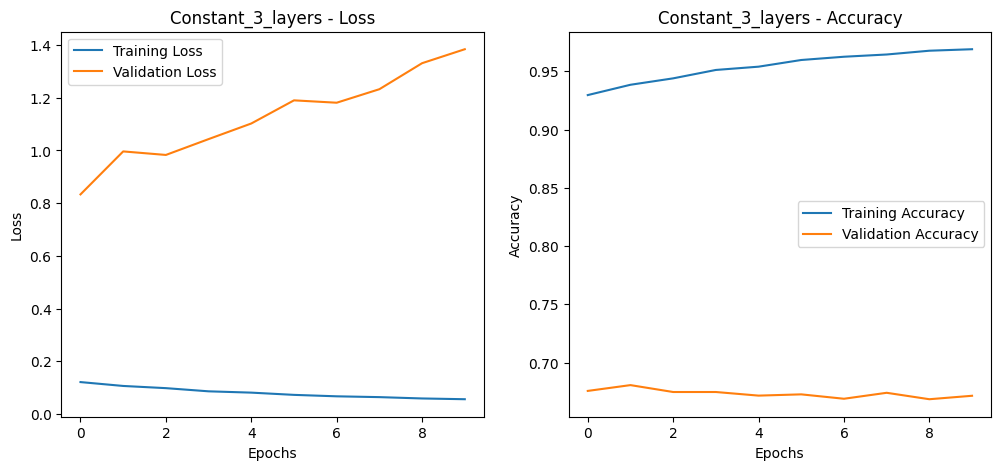

Scaled model
Training model with configuration: Constant_4_layers, Layers: [256, 256, 256, 256]


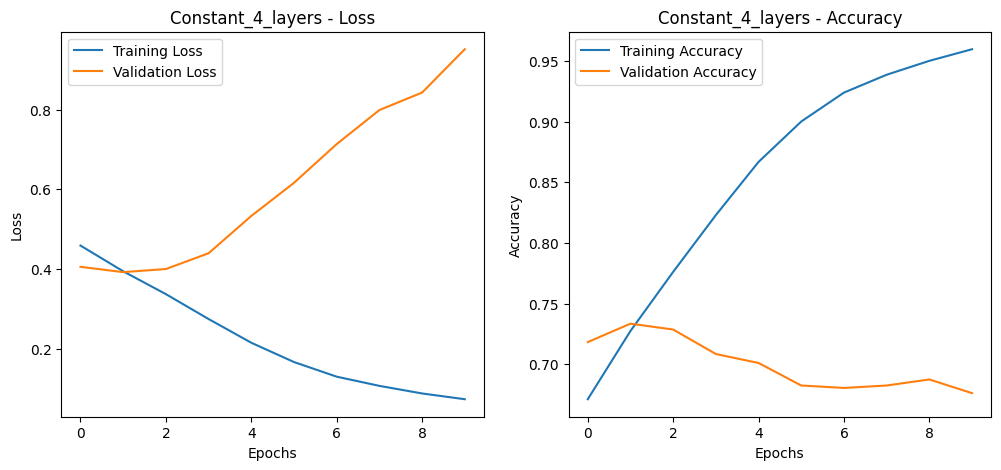

Original Model


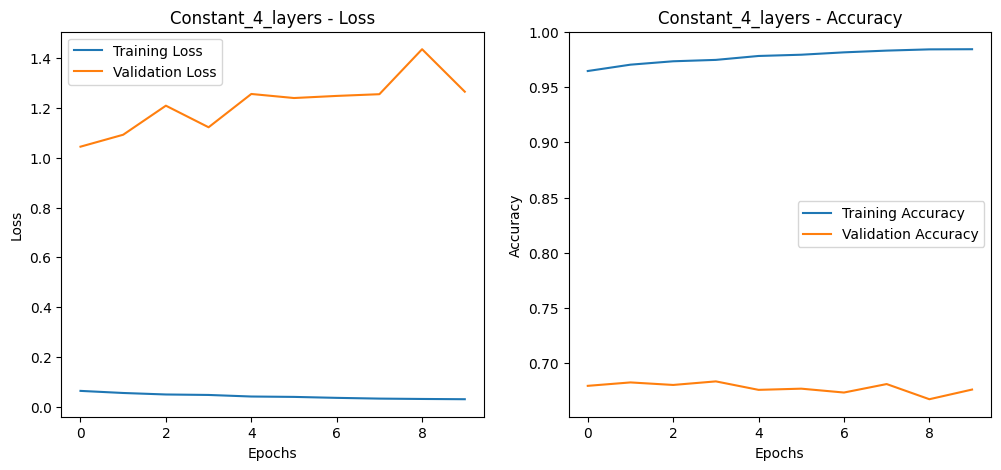

Scaled model


In [22]:
# Function to create and compile a neural network with varying hidden layers and nodes
def create_multi_layer_model(input_dim, layers_config):
    model = Sequential()
    model.add(Dense(layers_config[0], activation='relu', input_shape=(input_dim,)))

    # Adding additional hidden layers based on layers_config
    for nodes in layers_config[1:]:
        model.add(Dense(nodes, activation='relu'))

    model.add(Dense(3, activation='sigmoid'))  # Use 'softmax' for multi-class classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Function to train the model and plot training/validation loss and accuracy
def train_and_plot_model(type,model, X_train, y_train, X_val, y_val, epochs=50, title=""):
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=0)

    # Plotting training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{title} - Loss')

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{title} - Accuracy')
    plt.show()

    if(type ==0):
        print("Original Model")
    else:
        print("Scaled model")

# Define configurations for number of layers and nodes
layer_configs = {
    "Pyramid_1_layer": [32],
    "Pyramid_2_layers": [64, 32],
    "Pyramid_3_layers": [128, 64, 32],
    "Pyramid_4_layers": [256, 128, 64, 32],
    "Constant_1_layer": [32],
    "Constant_2_layers": [64, 64],
    "Constant_3_layers": [128, 128, 128],
    "Constant_4_layers": [256, 256, 256, 256],
}


input_dim = X_train.shape[1]  # Adjust to your dataset's input dimension

# Training and plotting for each configuration
for config_name, layers_config in layer_configs.items():
    print(f"Training model with configuration: {config_name}, Layers: {layers_config}")
    model = create_multi_layer_model(input_dim, layers_config)
    train_and_plot_model(0,model, X_train, y_train_categorical, X_test, y_test_categorical, epochs=10, title=config_name)
    train_and_plot_model(1,model, X_train_scaled, y_train_scaled_categorical, X_test_scaled, y_test_scaled_categorical, epochs=10, title=config_name)

**8b: Layers** <br>
From the above graphs, the validation is shown to get worse with each epoch. The training lines stay pretty smooth regardless of the node / layer count. The training accuracy lines still grow with each epoch in a sqrt(x) manor. Similar to the hidden node experiments, the validation loss grew overtime, the relationship resembles a linear function. The data seems to be subject to overfitting in the scaled data around the third layer in the pyramid experiments and the third layer in the constant experiments.



    - **Activation function**.

        - Present results for one of the configurations mentioned above by varying the activation function. Test at least `relu` (the default) and `sigmoid`. The choice of the specific model, including the number of layers and nodes, is at your discretion. Document your observations accordingly.

Epoch 1/10
911/911 [==============================] - 2s 2ms/step - loss: 0.4822 - accuracy: 0.6537 - val_loss: 0.4267 - val_accuracy: 0.7117
Epoch 2/10
911/911 [==============================] - 2s 2ms/step - loss: 0.4422 - accuracy: 0.6896 - val_loss: 0.4190 - val_accuracy: 0.7192
Epoch 3/10
911/911 [==============================] - 2s 2ms/step - loss: 0.4346 - accuracy: 0.6966 - val_loss: 0.4139 - val_accuracy: 0.7208
Epoch 4/10
911/911 [==============================] - 2s 2ms/step - loss: 0.4259 - accuracy: 0.7031 - val_loss: 0.4088 - val_accuracy: 0.7243
Epoch 5/10
911/911 [==============================] - 2s 2ms/step - loss: 0.4169 - accuracy: 0.7117 - val_loss: 0.4060 - val_accuracy: 0.7300
Epoch 6/10
911/911 [==============================] - 2s 2ms/step - loss: 0.4078 - accuracy: 0.7196 - val_loss: 0.4016 - val_accuracy: 0.7332
Epoch 7/10
911/911 [==============================] - 2s 2ms/step - loss: 0.3991 - accuracy: 0.7299 - val_loss: 0.3983 - val_accuracy: 0.7351
Epoch 

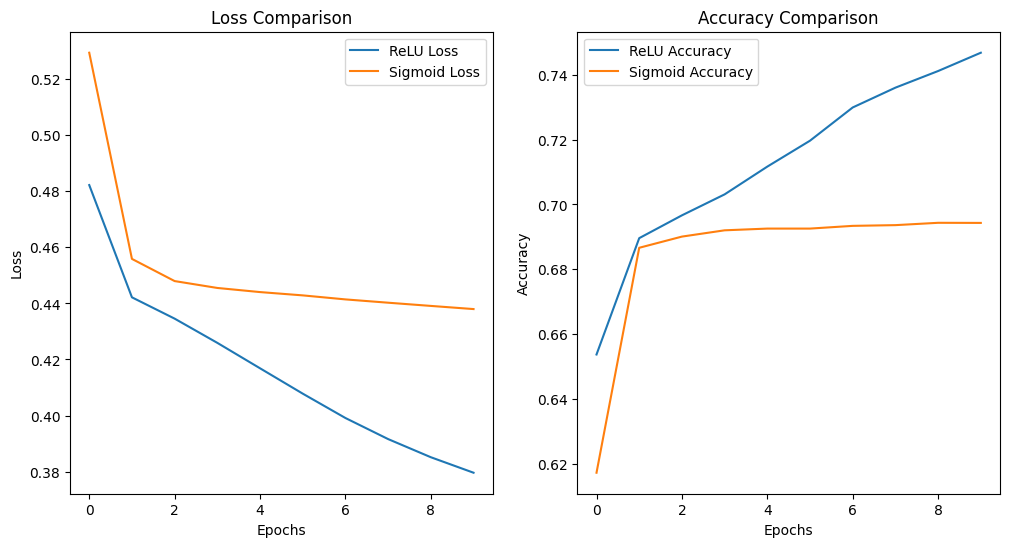

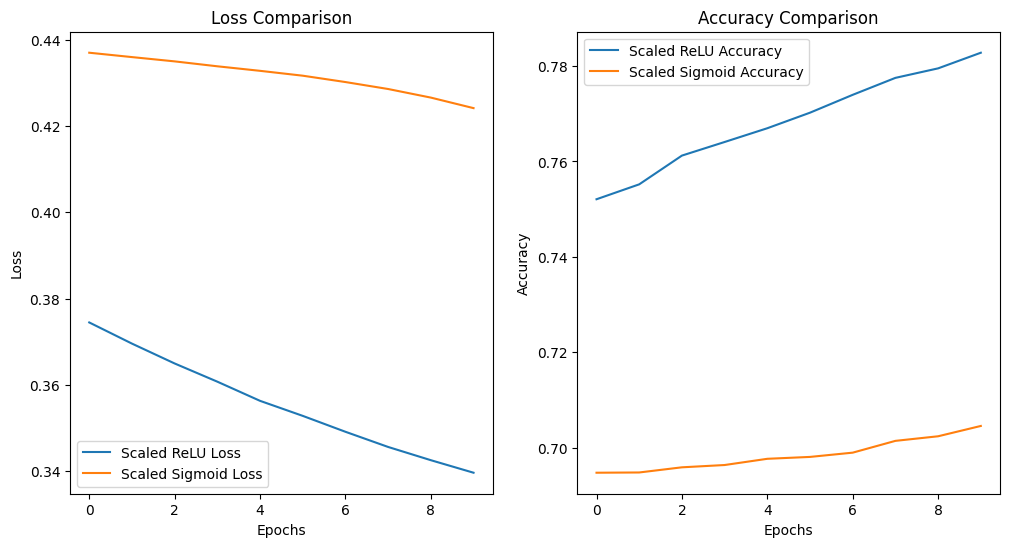

In [23]:
# Code cell


# Define model function
def create_model(activation_function='relu'):
    model = Sequential()

    model.add(Dense(32, activation=activation_function))

    model.add(Dense(3, activation='softmax'))  # Use 'softmax' for multi-class classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train with ReLU activation
model_relu = create_model('relu')
history_relu = model_relu.fit(X_train, y_train_categorical, epochs=10, batch_size=64, validation_data=(X_test, y_test_categorical))
scaled_history_relu = model_relu.fit(X_train_scaled, y_train_scaled_categorical, epochs=10, batch_size=64, validation_data=(X_test_scaled, y_test_scaled_categorical))


# Train with Sigmoid activation
model_sigmoid = create_model('sigmoid')
history_sigmoid = model_sigmoid.fit(X_train, y_train_categorical, epochs=10, batch_size=64, validation_data=(X_test, y_test_categorical))
scaled_history_sigmoid = model_sigmoid.fit(X_train_scaled, y_train_scaled_categorical, epochs=10, batch_size=64, validation_data=(X_test_scaled, y_test_scaled_categorical))

# Plot results
plt.figure(figsize=(12, 6))

# Loss comparison
plt.subplot(1, 2, 1)
plt.plot(history_relu.history['loss'], label='ReLU Loss')
plt.plot(history_sigmoid.history['loss'], label='Sigmoid Loss')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy comparison
plt.subplot(1, 2, 2)
plt.plot(history_relu.history['accuracy'], label='ReLU Accuracy')
plt.plot(history_sigmoid.history['accuracy'], label='Sigmoid Accuracy')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Plot results
plt.figure(figsize=(12, 6))

# Loss comparison
plt.subplot(1, 2, 1)
plt.plot(scaled_history_relu.history['loss'], label='Scaled ReLU Loss')
plt.plot(scaled_history_sigmoid.history['loss'], label='Scaled Sigmoid Loss')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy comparison
plt.subplot(1, 2, 2)
plt.plot(scaled_history_relu.history['accuracy'], label='Scaled ReLU Accuracy')
plt.plot(scaled_history_sigmoid.history['accuracy'], label='Scaled Sigmoid Accuracy')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**8c: Activation** <br>
We chose to test the one layer data on both the Relu and Sigmoid models. From the above graph we can see the ReLU models provided higher accuracy and less loss for both the original and scaled data. They has similar trends but overall the ReLU provided better results.


    - **Regularization** in neural networks is a technique used to prevent overfitting.

        - One technique involves adding a penalty to the loss function to discourage excessively complex models. Apply an `l2` penalty to some or all layers. Exercise caution, as overly aggressive penalties have been problematic in our experiments. Begin with the default `l2` value of 0.01, then reduce it to 0.001 and 1e-4. Select a specific model from the above experiments and present a case where you successfully reduced overfitting. Include a pair of graphs comparing results with and without regularization. Explain your rationale to conclude that overfitting has been reduced. Do not expect to completely eliminate overfitting. Again, this is a challenging dataset to work with.

Epoch 1/10
911/911 [==============================] - 2s 2ms/step - loss: 0.7949 - accuracy: 0.6571 - val_loss: 0.7056 - val_accuracy: 0.7123
Epoch 2/10
911/911 [==============================] - 2s 2ms/step - loss: 0.7348 - accuracy: 0.6886 - val_loss: 0.6947 - val_accuracy: 0.7189
Epoch 3/10
911/911 [==============================] - 2s 2ms/step - loss: 0.7221 - accuracy: 0.6958 - val_loss: 0.6895 - val_accuracy: 0.7215
Epoch 4/10
911/911 [==============================] - 2s 2ms/step - loss: 0.7053 - accuracy: 0.7036 - val_loss: 0.6788 - val_accuracy: 0.7285
Epoch 5/10
911/911 [==============================] - 2s 2ms/step - loss: 0.6831 - accuracy: 0.7153 - val_loss: 0.6668 - val_accuracy: 0.7314
Epoch 6/10
911/911 [==============================] - 2s 2ms/step - loss: 0.6601 - accuracy: 0.7276 - val_loss: 0.6522 - val_accuracy: 0.7337
Epoch 7/10
911/911 [==============================] - 2s 2ms/step - loss: 0.6401 - accuracy: 0.7361 - val_loss: 0.6490 - val_accuracy: 0.7382
Epoch 

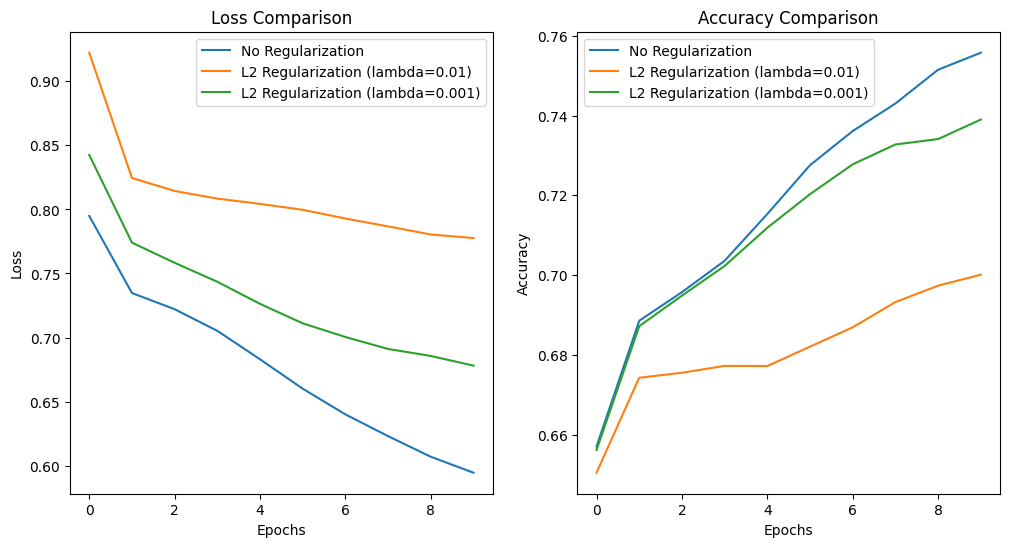

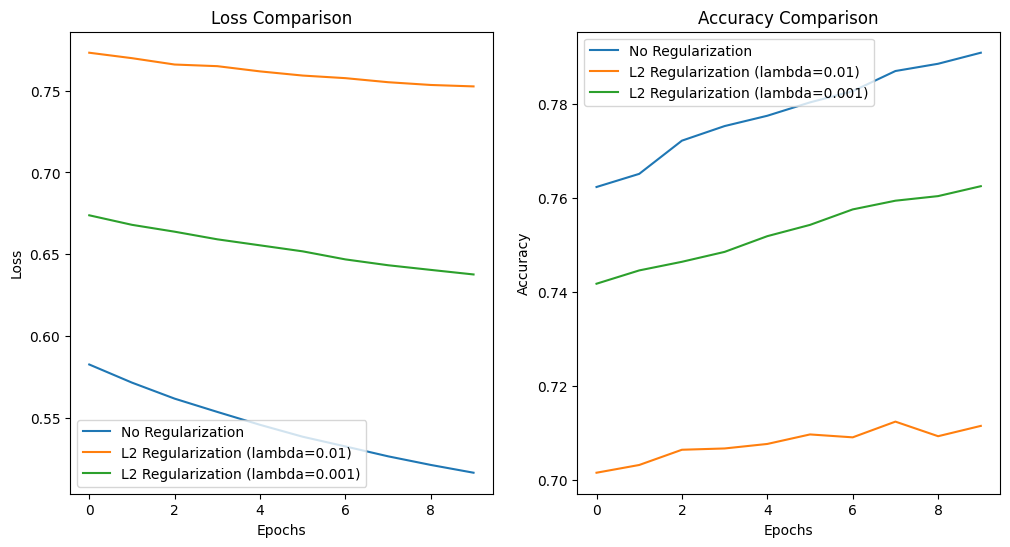

In [26]:
from tensorflow.keras.optimizers import Adam

# Code cell
# Function to create model with L2 regularization
from tensorflow.keras.regularizers import l2
def create_model_with_regularization(l2_lambda=0.01):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(input_dim,), kernel_regularizer=l2(l2_lambda)))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train model with no regularization (l2_lambda=0)
model_no_reg = create_model_with_regularization(0)
history_no_reg = model_no_reg.fit(X_train, y_train_categorical, epochs=10, batch_size=64, validation_data=(X_test, y_test_categorical))
scaled_history_no_reg = model_no_reg.fit(X_train_scaled, y_train_scaled_categorical, epochs=10, batch_size=64, validation_data=(X_test_scaled, y_test_scaled_categorical))

# Train model with regularization (l2_lambda=0.01)
model_l2_001 = create_model_with_regularization(0.01)
history_l2_001 = model_l2_001.fit(X_train, y_train_categorical, epochs=10, batch_size=64, validation_data=(X_test, y_test_categorical))
scaled_history_l2_001 = model_l2_001.fit(X_train_scaled, y_train_scaled_categorical, epochs=10, batch_size=64, validation_data=(X_test_scaled, y_test_scaled_categorical))

# Train model with regularization (l2_lambda=0.001)
model_l2_0001 = create_model_with_regularization(0.001)
history_l2_0001 = model_l2_0001.fit(X_train, y_train_categorical, epochs=10, batch_size=64, validation_data=(X_test, y_test_categorical))
scaled_history_l2_0001 = model_l2_0001.fit(X_train_scaled, y_train_scaled_categorical, epochs=10, batch_size=64, validation_data=(X_test_scaled, y_test_scaled_categorical))

# Plot results to compare
plt.figure(figsize=(12, 6))

# Loss comparison
plt.subplot(1, 2, 1)
plt.plot(history_no_reg.history['loss'], label='No Regularization')
plt.plot(history_l2_001.history['loss'], label='L2 Regularization (lambda=0.01)')
plt.plot(history_l2_0001.history['loss'], label='L2 Regularization (lambda=0.001)')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy comparison
plt.subplot(1, 2, 2)
plt.plot(history_no_reg.history['accuracy'], label='No Regularization')
plt.plot(history_l2_001.history['accuracy'], label='L2 Regularization (lambda=0.01)')
plt.plot(history_l2_0001.history['accuracy'], label='L2 Regularization (lambda=0.001)')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Plot results to compare
plt.figure(figsize=(12, 6))

# Loss comparison
plt.subplot(1, 2, 1)
plt.plot(scaled_history_no_reg.history['loss'], label='No Regularization')
plt.plot(scaled_history_l2_001.history['loss'], label='L2 Regularization (lambda=0.01)')
plt.plot(scaled_history_l2_0001.history['loss'], label='L2 Regularization (lambda=0.001)')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy comparison
plt.subplot(1, 2, 2)
plt.plot(scaled_history_no_reg.history['accuracy'], label='No Regularization')
plt.plot(scaled_history_l2_001.history['accuracy'], label='L2 Regularization (lambda=0.01)')
plt.plot(scaled_history_l2_0001.history['accuracy'], label='L2 Regularization (lambda=0.001)')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**8d: Regulation** <br>
From the data above, it can be seen that overfitting was reduced as the regularized data follows much mre closly to the validation data seen in previous graphs. In the scaled data it was very obvious when there was overfitting as it was almost a straight line at the top of each graph for accuracy and the same at the bottom of the graph for loss. With regularization the two values can be more evened out and arguably closer to what they should be.


        - Dropout layers are a regularization technique in neural networks where a random subset of neurons is temporarily removed during training. This helps prevent overfitting by promoting redundancy and improving the network's ability to generalize to new data. Select a specific model from the above experiments where you have muliple layers and experiment adding one or of few dropout layers into your network. Experiment with two different rates, say 0.25 and 0.5. Document your observations.

Epoch 1/10
911/911 [==============================] - 3s 3ms/step - loss: 0.7791 - accuracy: 0.6623 - val_loss: 0.6889 - val_accuracy: 0.7201
Epoch 2/10
911/911 [==============================] - 2s 3ms/step - loss: 0.7057 - accuracy: 0.7024 - val_loss: 0.6595 - val_accuracy: 0.7277
Epoch 3/10
911/911 [==============================] - 2s 3ms/step - loss: 0.6447 - accuracy: 0.7314 - val_loss: 0.6451 - val_accuracy: 0.7304
Epoch 4/10
911/911 [==============================] - 2s 3ms/step - loss: 0.5971 - accuracy: 0.7532 - val_loss: 0.6465 - val_accuracy: 0.7298
Epoch 5/10
911/911 [==============================] - 2s 3ms/step - loss: 0.5564 - accuracy: 0.7717 - val_loss: 0.6700 - val_accuracy: 0.7267
Epoch 6/10
911/911 [==============================] - 2s 3ms/step - loss: 0.5186 - accuracy: 0.7901 - val_loss: 0.6935 - val_accuracy: 0.7180
Epoch 7/10
911/911 [==============================] - 2s 3ms/step - loss: 0.4861 - accuracy: 0.8034 - val_loss: 0.7103 - val_accuracy: 0.7145
Epoch 

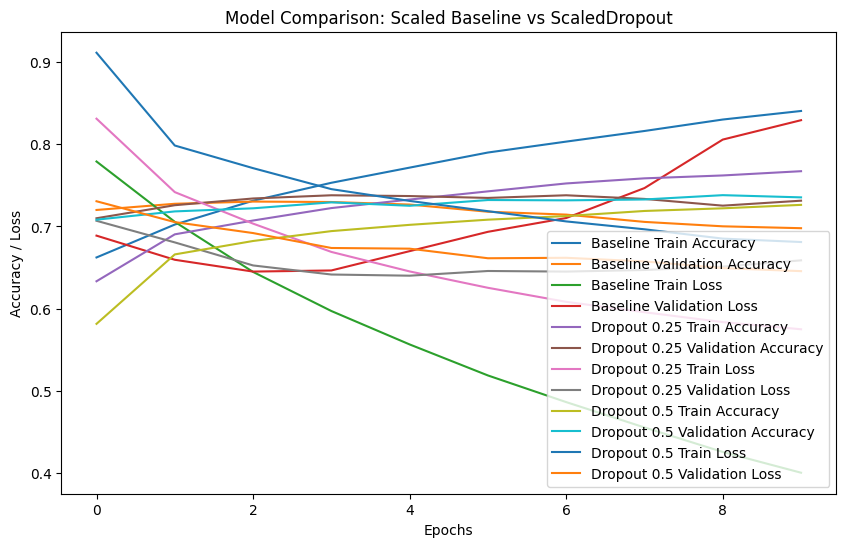

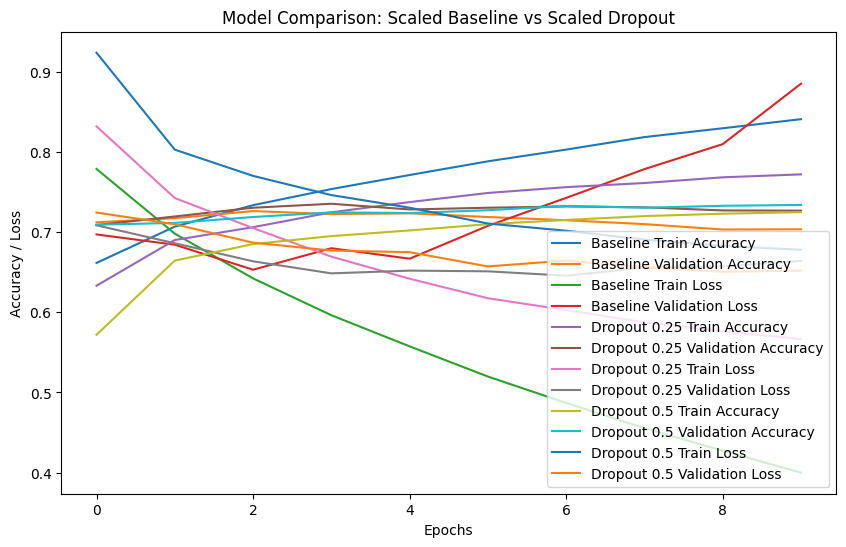

In [27]:
# Code cell
from tensorflow.keras.layers import Dropout

# Baseline model with three hidden layers
def baseline_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(input_dim,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def model_with_dropout_0_25():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(0.25))  # Adding dropout with 0.25 rate
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))  # Adding dropout with 0.25 rate
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))  # Adding dropout with 0.25 rate
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def model_with_dropout_0_5():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(0.5))  # Adding dropout with 0.5 rate
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Adding dropout with 0.5 rate
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))  # Adding dropout with 0.5 rate
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

history_baseline = baseline_model().fit(X_train, y_train_categorical, epochs=10, batch_size=64, validation_data=(X_test, y_test_categorical))
history_0_25 = model_with_dropout_0_25().fit(X_train, y_train_categorical, epochs=10, batch_size=64, validation_data=(X_test, y_test_categorical))
history_0_5 = model_with_dropout_0_5().fit(X_train, y_train_categorical, epochs=10, batch_size=64, validation_data=(X_test, y_test_categorical))

scaled_history_baseline = baseline_model().fit(X_train_scaled, y_train_scaled_categorical, epochs=10, batch_size=64, validation_data=(X_test_scaled, y_test_scaled_categorical))
scaled_history_0_25 = model_with_dropout_0_25().fit(X_train_scaled, y_train_scaled_categorical, epochs=10, batch_size=64, validation_data=(X_test_scaled, y_test_scaled_categorical))
scaled_history_0_5 = model_with_dropout_0_5().fit(X_train_scaled, y_train_scaled_categorical, epochs=10, batch_size=64, validation_data=(X_test_scaled, y_test_scaled_categorical))

def plot_history(history, model_name):
    plt.plot(history.history['accuracy'], label=f'{model_name} Train Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'{model_name} Validation Accuracy')
    plt.plot(history.history['loss'], label=f'{model_name} Train Loss')
    plt.plot(history.history['val_loss'], label=f'{model_name} Validation Loss')

plt.figure(figsize=(10, 6))
plot_history(history_baseline, 'Baseline')
plot_history(history_0_25, 'Dropout 0.25')
plot_history(history_0_5, 'Dropout 0.5')
plt.legend()
plt.title('Model Comparison: Scaled Baseline vs ScaledDropout')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.show()

plt.figure(figsize=(10, 6))
plot_history(scaled_history_baseline, 'Baseline')
plot_history(scaled_history_0_25, 'Dropout 0.25')
plot_history(scaled_history_0_5, 'Dropout 0.5')
plt.legend()
plt.title('Model Comparison: Scaled Baseline vs Scaled Dropout')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.show()

**8e: Dropout** <br>
From the graph above we can see that the dropout values made changes to both the training and validation data. As all the lines do intersect, they do start having a semblance of conversion with the dropout rates.

        - Summarize your experiments with using a graphical representation such as Figure 6.15 [on this page](https://egallic.fr/Enseignement/ML/ECB/book/deep-learning.html).

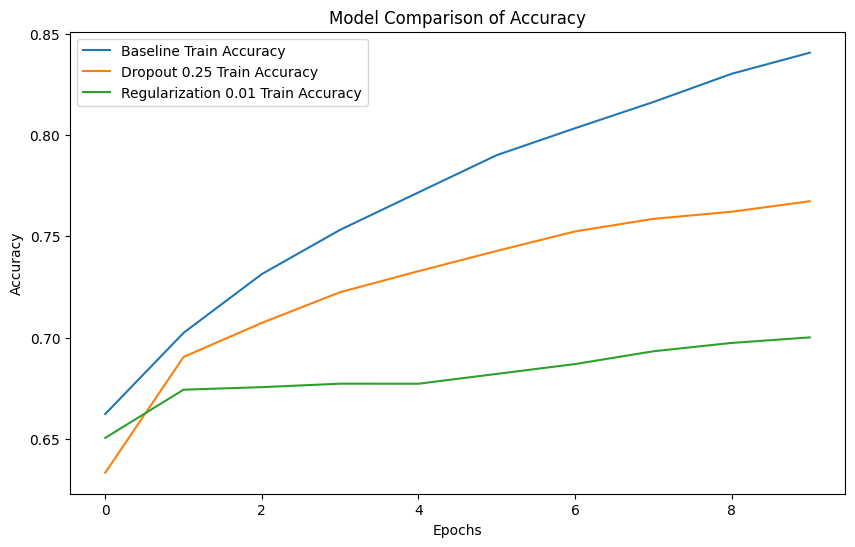

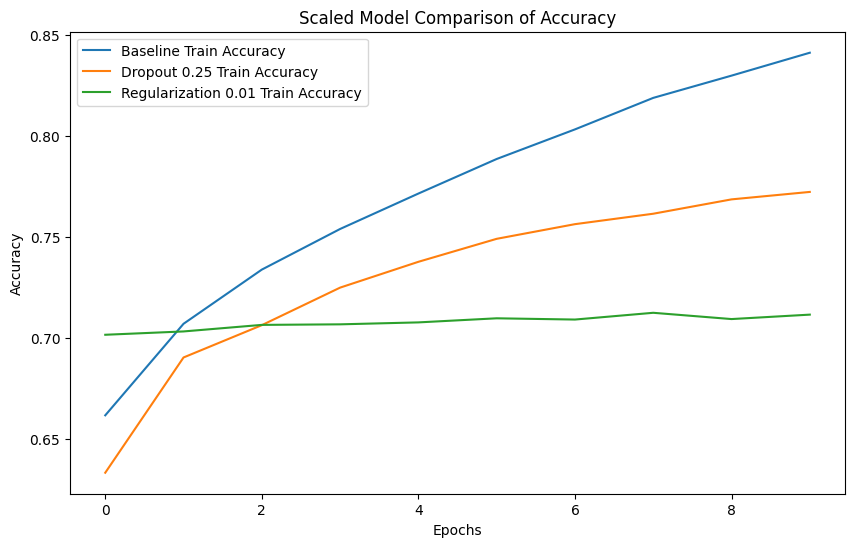

In [28]:
# Code cell
def plot_acc(history, model_name):
        plt.plot(history.history['accuracy'], label=f'{model_name} Train Accuracy')

plt.figure(figsize=(10, 6))
plot_acc(history_baseline, 'Baseline')
plot_acc(history_0_25, 'Dropout 0.25')
plot_acc(history_l2_001, 'Regularization 0.01')
plt.legend()
plt.title('Model Comparison of Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.figure(figsize=(10, 6))
plot_acc(scaled_history_baseline, 'Baseline')
plot_acc(scaled_history_0_25, 'Dropout 0.25')
plot_acc(scaled_history_l2_001, 'Regularization 0.01')
plt.legend()
plt.title('Scaled Model Comparison of Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

**8f: Comparison** <br>
Though the dropout rates did stabilize the data a bit, we can see in the graphs that the regularization was a better process to apply to the data.

        - Early stopping is a regularization technique in neural network training wherein the process is halted when validation set performance starts to decline, thus preventing overfitting by avoiding the learning of noise in the training data. From all the experiments conducted thus far, choose **one** configuration (the number of layers, number of nodes, activation function, L2 penalty, and dropout layers) that yielded the best performance. Use a graph of loss and accuracy to determine the optimal number of training iterations for this network. What is the optimal number of epochs for this network configuration and why?

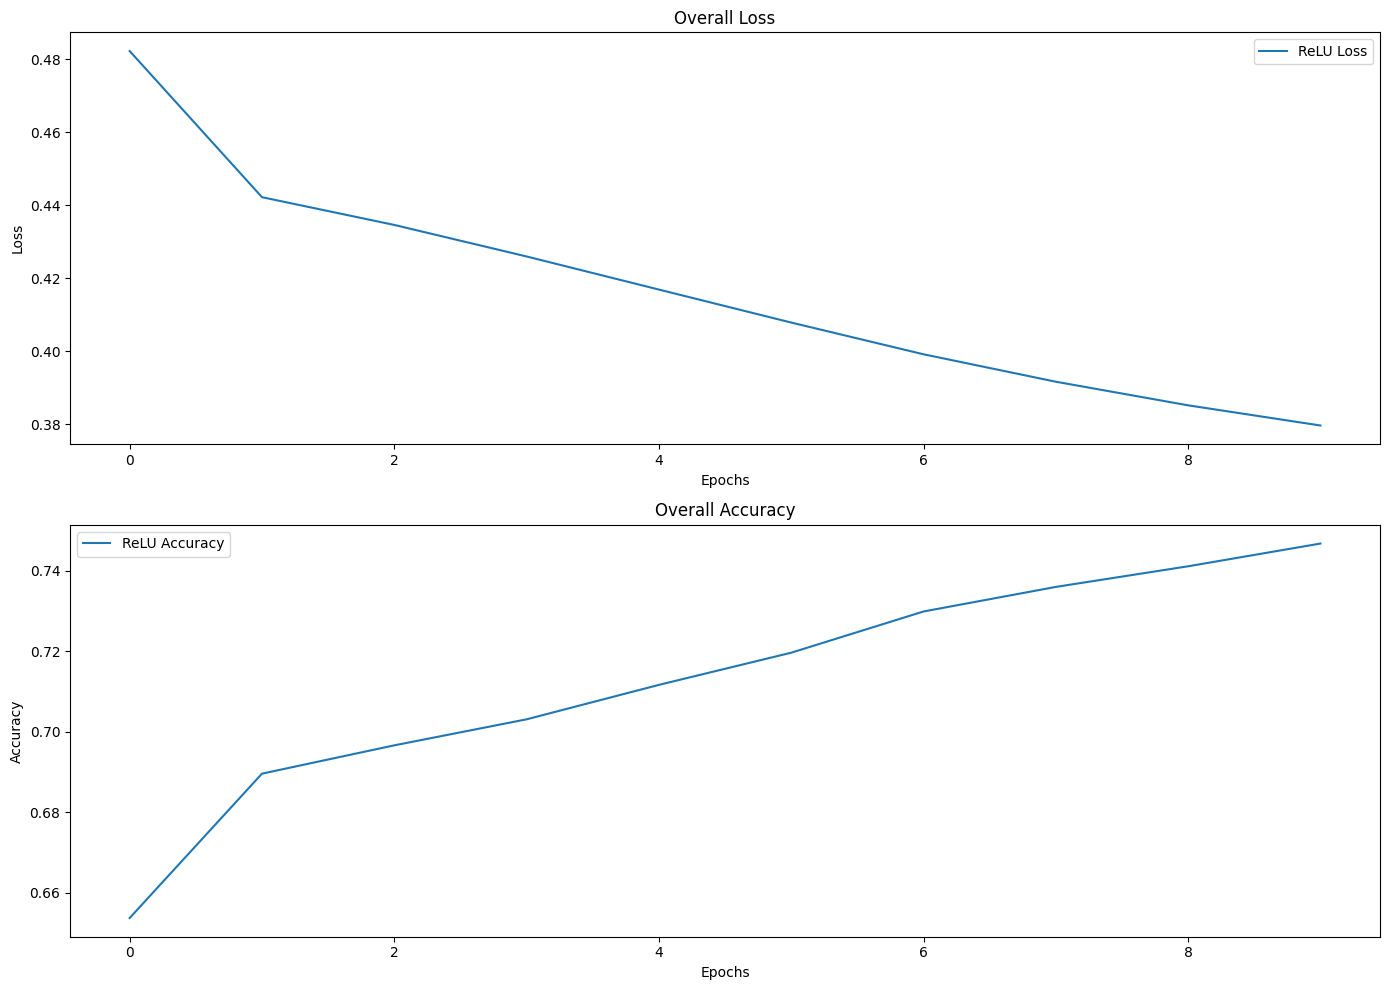

In [30]:
# Code cell
# Initialize the figure
plt.figure(figsize=(14, 10))

# Loss comparison
plt.subplot(2, 1, 1)
# Chosen parameters
plt.plot(history_relu.history['loss'], label='ReLU Loss')

plt.title('Overall Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy comparison
plt.subplot(2, 1, 2)
# Original (unscaled) ReLU and Sigmoid
plt.plot(history_relu.history['accuracy'], label='ReLU Accuracy')

plt.title('Overall Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**8g: Overall** <br>
We concluded that the best number of epochs for this data was 10-15.

### Test

9. **Model Comparison**:

    - Evaluate the baseline model on the test set, using the optimal parameter set identified through grid search. Additionally, apply your best-performing neural network configuration to the test set.

    - Quantify the performance of the baseline model (best hyperparameter configuration) and your neural network (best configuration) using precision, recall, and F1-score as metrics. How do these two models compare to the dummy model?

    - Provide recommendations on which model(s) to choose for this task and justify your choices based on the analysis results.

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression

# Best hyperparameters for baseline model
best_params = {'max_iter': 50, 'penalty': 'l2', 'tol': 0.001}

baseline_model = LogisticRegression(**best_params)
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)
baseline_precision = precision_score(y_test, y_pred_baseline, average='weighted')
baseline_recall = recall_score(y_test, y_pred_baseline, average='weighted')
baseline_f1 = f1_score(y_test, y_pred_baseline, average='weighted')

print("Baseline Model Performance on Unscaled Data:")
print(f"Precision: {baseline_precision:.4f}")
print(f"Recall: {baseline_recall:.4f}")
print(f"F1-Score: {baseline_f1:.4f}")

baseline_model_scaled = LogisticRegression(**best_params)
baseline_model_scaled.fit(X_train_scaled, y_train_scaled)
y_pred_baseline_scaled = baseline_model_scaled.predict(X_test_scaled)

baseline_precision_scaled = precision_score(y_test_scaled, y_pred_baseline_scaled, average='weighted')
baseline_recall_scaled = recall_score(y_test_scaled, y_pred_baseline_scaled, average='weighted')
baseline_f1_scaled = f1_score(y_test_scaled, y_pred_baseline_scaled, average='weighted')

print("Baseline Model Performance on Scaled Data:")
print(f"Precision: {baseline_precision_scaled:.4f}")
print(f"Recall: {baseline_recall_scaled:.4f}")
print(f"F1-Score: {baseline_f1_scaled:.4f}")


Baseline Model Performance on Unscaled Data:
Precision: 0.7158
Recall: 0.7164
F1-Score: 0.7134
Baseline Model Performance on Scaled Data:
Precision: 0.7125
Recall: 0.7135
F1-Score: 0.7108


In [42]:
y_pred_nn = nn_model.predict(X_test)
y_pred_nn = y_pred_nn.argmax(axis=1)

nn_precision = precision_score(y_test, y_pred_nn, average='weighted')
nn_recall = recall_score(y_test, y_pred_nn, average='weighted')
nn_f1 = f1_score(y_test, y_pred_nn, average='weighted')

print("NN Model Performance on Unscaled Data:")
print(f"Precision: {nn_precision:.4f}")
print(f"Recall: {nn_recall:.4f}")
print(f"F1-Score: {nn_f1:.4f}")

y_pred_nn_scaled = nn_scaled_model.predict(X_test_scaled)
y_pred_nn_scaled = y_pred_nn_scaled.argmax(axis=1)
nn_precision_scaled = precision_score(y_test_scaled, y_pred_nn_scaled, average='weighted')
nn_recall_scaled = recall_score(y_test_scaled, y_pred_nn_scaled, average='weighted')
nn_f1_scaled = f1_score(y_test_scaled, y_pred_nn_scaled, average='weighted')


print("NN Model Performance on Scaled Data:")
print(f"Precision: {nn_precision_scaled:.4f}")
print(f"Recall: {nn_recall_scaled:.4f}")
print(f"F1-Score: {nn_f1_scaled:.4f}")

233/233 [==============================] - 0s 2ms/step
NN Model Performance on Unscaled Data:
Precision: 0.6846
Recall: 0.6864
F1-Score: 0.6848
233/233 [==============================] - 0s 2ms/step
NN Model Performance on Scaled Data:
Precision: 0.6835
Recall: 0.6851
F1-Score: 0.6838


Our performance on the baseline model with hyperparameters met expectations with the overall scores being evenly disbruted and around 0.7 on both the regular and scaled models. Because there was a lot of overfitting within the scaled model more than the regular one, we would choose not to scale the data to get better results.

# Resources

https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.MinMaxScaler.html <br>
https://www.tensorflow.org/guide/keras/sequential_model <br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers